## Import packages

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, RobustScaler, quantile_transform, QuantileTransformer

# Sklearn models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import f_regression,mutual_info_regression, RFE, SelectFromModel, SelectKBest

from joblib import Parallel, delayed

from gplearn.genetic import SymbolicRegressor

from sklearn.metrics import r2_score

import math

## Methods

In [2]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, list_of_features):
        self.list_of_features = list(list_of_features)

    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return pd.DataFrame(x[self.list_of_features])

class Winsorize(BaseEstimator, TransformerMixin):
    def __init__(self, lower = 0.01, higher = 99.9):
        self.lower = lower
        self.higher = higher
        
        self.colrange = None
        self.lowerMap = None
        self.higherMap = None

    def fit(self, x, y=None):
        self.lowerMap = {}
        self.higherMap = {}
        
        self.colrange = x.shape[1]
        
        for i in range(0, self.colrange):
            self.lowerMap[i] = np.percentile(x[:,i], self.lower)
            self.higherMap[i] = np.percentile(x[:,i], self.higher)
            
        return self

    def transform(self, x):
        res = np.array(x)
        for i in range(0, self.colrange):
            res[:,i][res[:,i] < self.lowerMap[i]] = self.lowerMap[i]
            res[:,i][res[:,i] > self.higherMap[i]] = self.higherMap[i]
        
        
        return res

class clip_estimator(BaseEstimator, TransformerMixin):
    def __init__(self, low = -0.0860941, high=0.093498, clf = LinearRegression()):
        self.low = low
        self.high = high
        self.clf = clf

    def fit(self, x, y=None):
        self.clf.fit(x, y)

    def predict(self, x):
        y = self.clf.predict(x)
        y[y < self.low] = self.low
        y[y > self.high] = self.high
        return y
    
    def score(self, x, y_true):
        "Return R as the score."
        y_fit = self.predict(x)
        R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
        R = np.sign(R2) * math.sqrt(abs(R2))
        return(R)
        
        
'''
Following is not used in the submission.

'''

def histplot(path, filled_train, transformed_train = None):
    if transformed_train is None:
        
        for col in filled_train.columns:
            plt.figure(figsize = (6,6))
            plt.ioff()
            plt.hist(filled_train[col], bins = 100)
            plt.title(col)
            plt.savefig(path + col + ".png")
    else:
        
        for col in transformed_train.columns:
            
            plt.figure(figsize = (16,8))
            plt.ioff()
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

            ax1.hist(filled_train[col], bins = 100)
            ax1.set_title("Raw")

            ax2.hist(transformed_train[col], bins = 100)
            ax2.set_title("Transformed")

            f.savefig(path + col + ".png")
'''
Version one of benchmark:
'''      
def bench_col_by_col(X_train, X_trans, y_train, sort = True, verbose = 10, oob = True):
    clf = LinearRegression()
    
    before = []
    after = []
    col_name = []
    
    steps = 0
    
    for col in X_train:
        steps = steps + 1
        if steps%10 == 0:
            print(steps)
        if oob:
            without_score = cross_val_score(clf, X_train[col].values.reshape(-1,1), y_train, n_jobs = 4, cv = 4)
            with_score = cross_val_score(clf, X_trans[col].values.reshape(-1,1), y_train, n_jobs = 4, cv = 4)
        else:
            clf.fit(X_train[col].values.reshape(-1,1), y_train)
            without_score = clf.score(X_train[col].values.reshape(-1,1), y_train)
            
            clf.fit(X_trans[col].values.reshape(-1,1), y_train)
            with_score = clf.score(X_trans[col].values.reshape(-1,1), y_train)            
            
        if verbose < 10:
            print("R_" + col + str(without_score))
            print("T_" + col + str(with_score))
        
        before.append(np.mean(without_score))
        after.append(np.mean(with_score))
        col_name.append(col)
        
    
    df = pd.DataFrame({"cv_before" : before,
                      "cv_after" : after,
                      "colname" : col_name})
    df.set_index("colname")
    return df.sort_values(by = "cv_before")[-10:]


def bench_process(l):
    clf1 =  clip_estimator(low = -0.0860941,high=0.093498)
    scoreRaw = cross_val_score(clf1, l[0], l[2])
    scoreT = cross_val_score(clf1, l[1], l[2])
    return [l[3], np.mean(scoreRaw), np.mean(scoreT)]

def bench_col_by_col_parallel(a, b, c, sort = True, verbose = 10, oob = True):
    
    before = []
    after = []
    col_name = []
    
    
    res = Parallel(n_jobs=16, verbose = 10)(delayed(bench_process)([a[col].values.reshape(-1,1),
                                               b[col].values.reshape(-1,1),
                                               c,
                                               col]) for col in a.columns)
    length = len(res)
    Id = []
    raw_score = []
    tf_score = []
    increase = []
    for i in range(0,length):
        Id.append(res[i][0])
        raw_score.append(res[i][1])
        tf_score.append(res[i][2])
        increase.append(res[i][2] - res[i][1])
    res = pd.DataFrame({"id": Id,
                        "raw_score":raw_score,
                        "winsorized_score":tf_score,
                        "score_diff":increase})
    
    return res.set_index("id").sort_values("raw_score")

v_min = -0.0860941
v_max = 0.093498


## Gym environment

In [4]:
class Observation(object):
    def __init__(self, train, target, features):
        self.train = train
        self.target = target
        self.features = features

class Environment(object):
    def __init__(self):
        with pd.HDFStore("/home/xin/data_analysis/raw_data/ts_datathon/train.h5", "r") as hfdata:
            self.timestamp = 0
            fullset = hfdata.get("train")
            self.unique_timestamp = fullset["timestamp"].unique()
            # Get a list of unique timestamps
            # use the first half for training and
            # the second half for the test set
            n = len(self.unique_timestamp)
            i = 0
            timesplit = self.unique_timestamp[i]
            self.n = n
            self.unique_idx = i
            self.train = fullset[fullset.timestamp < n]
            self.test = fullset[fullset.timestamp < n]

    def reset(self):
        timesplit = self.unique_timestamp[self.unique_idx]
        self.unique_idx = self.unique_idx + 1
        subset = self.test[self.test.timestamp == timesplit]
        target = subset.loc[:, ['id', 'y']]
        features = subset.iloc[:, 0:111]
        observation = Observation(self.train, target, features)
        return observation

    def step(self, target):
        if self.unique_idx == self.n:
            done = True
            observation = None
            reward = None
            info = {}
        else:
            timesplit = self.unique_timestamp[self.unique_idx]
            self.unique_idx = self.unique_idx + 1
            subset = self.test[self.test.timestamp == timesplit]
            target = subset.loc[:, ['id', 'y']]
            features = subset.iloc[:, 0:111]
            observation = Observation(None, target, features)
            reward = 0
            done = False
            if len(observation.features) == 0:
                done = True
            info = {}
        return observation, reward, done, info

    def __str__(aself):
        return "Environment()"


def make():
    return Environment()


## Feature engineer

In [5]:
# Get augmented column list
def derive_col_list(frame):
    original_cols = list(frame.columns)
    original_cols.remove("id")
    original_cols.remove("timestamp")
    original_cols.remove("y")
    col_list = [
        original_cols,
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
    ]
    for col in original_cols:
        if col not in ["id", "timestamp"]:
            for i in range(1,7):
                col_list[i].append("a.lag_" + str(i) + "." + col)
            col_list[7].append("b.diff." + col)
            col_list[8].append("c.absdiff." + col)
            col_list[9].append("d.EMWA." + col)
            col_list[10].append("e.mean." + col)
            col_list[11].append("f.detmean." + col)
            col_list[12].append("g.deEWMA." + col)
    return col_list

In [6]:
def aug_ob(cur_ob, col_list, prev_ob = None, full_ob = None):
    weight = 0.9
    cur_mean = cur_ob.mean()
    cur_time = cur_ob["timestamp"].iloc[0]
    
    '''
    Create a frame:
        cur_ob_id_index: current observation with id as index
    '''
    cur_ob_id_index = cur_ob.set_index("id")
    
    for i in range(1,13):
        for col in col_list[i]:
            cur_ob_id_index[col] = np.nan
    
    cur_ob_id_index[col_list[12]] = 0
    
    if prev_ob is None:
        for i in range(1,7):
            cur_ob_id_index[col_list[i]] = cur_ob_id_index[col_list[0]]        
    
    
    # Step 1: Amean
    for col in col_list[10]:
        operation_list = col.split(".")
        cur_ob_id_index[col] = cur_mean[operation_list[2]]
        
    # Step 2: Demean
    for col in col_list[11]:
        operation_list = col.split(".")
        cur_ob_id_index[col] = cur_ob_id_index[operation_list[2]] - cur_mean[operation_list[2]]
    
    # Step 3: SumLAG EMWA
    for col in col_list[9]:
        operation_list = col.split(".")
        cur_ob_id_index[col] = cur_ob_id_index[operation_list[2]]

    # Other features like lags depend on previous observation.
    if prev_ob is not None:
        prev_ob_id_index = prev_ob.set_index("id")
        #Step 3: Lags
        
        for i in range(0,6):
            j = 6 - i
            prev_ob_id_index[col_list[j]] = prev_ob_id_index[col_list[j - 1]]
        
        for i in range(1,7):
            cur_ob_id_index.update(prev_ob_id_index[col_list[i]])
        cur_ob_id_index.update(prev_ob_id_index[col_list[9]])
        
        for i in range(0, len(col_list[7])):
            cur_ob_id_index[col_list[7][i]] = cur_ob_id_index[col_list[0][i]] - cur_ob_id_index[col_list[1][i]]
            cur_ob_id_index[col_list[8][i]] = abs(cur_ob_id_index[col_list[0][i]] - cur_ob_id_index[col_list[1][i]])
            cur_ob_id_index[col_list[9][i]] = cur_ob_id_index[col_list[0][i]] * weight + cur_ob_id_index[col_list[9][i]] * (1 - weight)
            cur_ob_id_index[col_list[12][i]] = cur_ob_id_index[col_list[0][i]] - cur_ob_id_index[col_list[9][i]]
    
    return cur_ob_id_index.reset_index()

In [7]:
env = make()
observation = env.reset()
col_list = derive_col_list(observation.features.iloc[:,0:111])
prev_ob = pd.DataFrame(observation.features.iloc[:,0:111])
print(prev_ob["timestamp"].iloc[0])

col_list = derive_col_list(prev_ob)
prev_ob = aug_ob(prev_ob, col_list)
full_frame = pd.DataFrame(prev_ob)
temp_frame = pd.DataFrame()
step = 1

while True:
    [observation, reward, done, info] = env.step(1)
    ob = pd.DataFrame(observation.features.iloc[:,0:111])
    print(ob["timestamp"].iloc[0])
    prev_ob = aug_ob(ob, col_list, prev_ob = prev_ob)
    temp_frame = temp_frame.append(prev_ob, ignore_index=True)
    if done:
        full_frame = full_frame.append(temp_frame, ignore_index=True)
        temp_frame = pd.DataFrame()
        break
    if step % 50 == 0:
        full_frame = full_frame.append(temp_frame, ignore_index=True)
        temp_frame = pd.DataFrame()
    step = step + 1
    
full_frame.to_pickle("/home/xin/best_params/09weight.p")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

AttributeError: 'NoneType' object has no attribute 'features'

In [8]:
full_frame.to_pickle("/home/xin/best_params/aug_frame.p")

## Data exploration

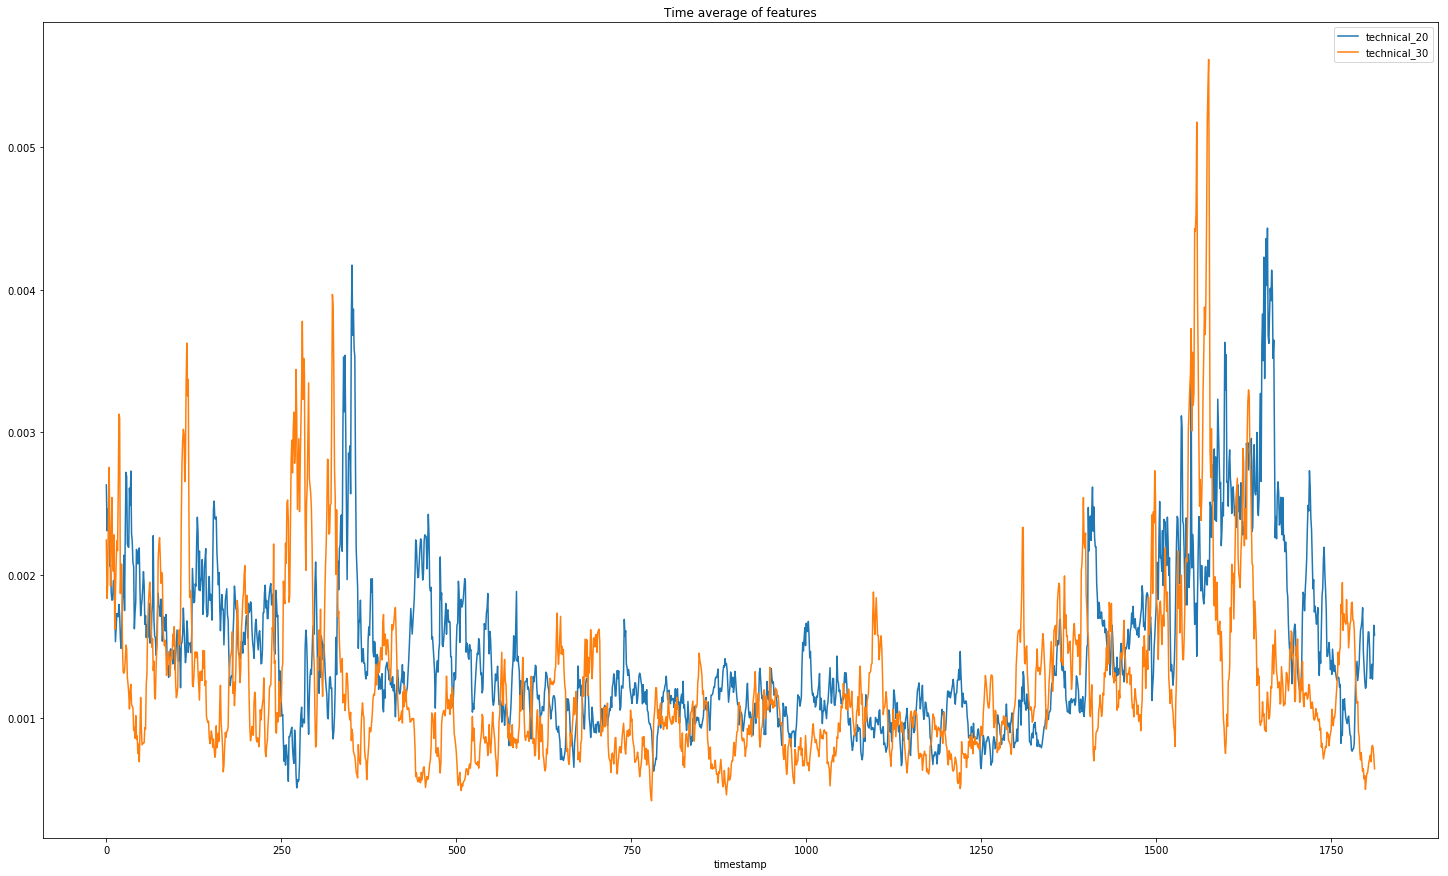

In [26]:
%matplotlib inline
group_mean = full_frame.groupby("timestamp").mean()
group_mean[['technical_20','technical_30']].plot(figsize=(25,15), title = "Time average of features")

In [10]:
import gc
full_frame = None
true_val = None
raw_data = None
gc.collect()

87

In [403]:
# Compute median
med = f_frame.median()

In [405]:
feature_name = []
score = []
f_frame.fillna(med, inplace = True)

for col in f_frame.columns:
    if col in ["id", "timestamp", "y"]:
        continue
    feature_name.append(col)
    score.append(abs(np.corrcoef(f_frame[col], f_frame['y'])[0,1]))
correlation = pd.DataFrame({"feature" : feature_name,
                          "y_abs_corr" :score})

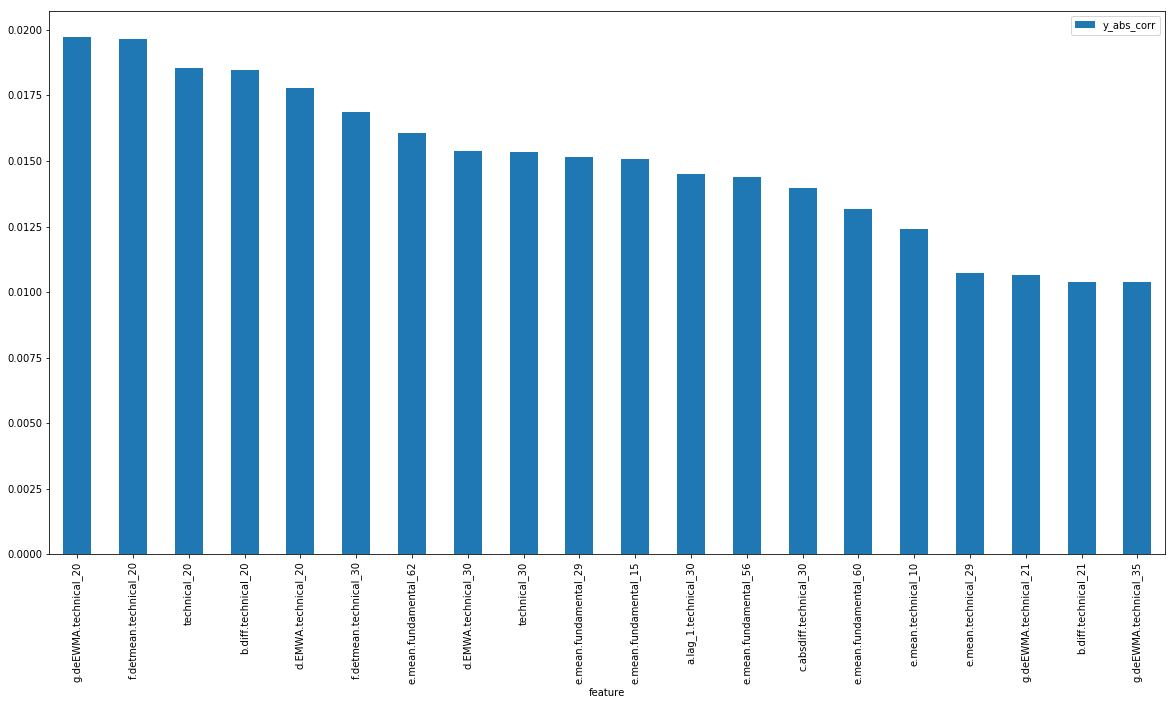

In [41]:
%matplotlib inline
correlation.sort_values("y_abs_corr",
                        ascending = False).set_index("feature")[0:20].plot(kind = "bar", figsize = (20, 10))

In [5]:
#correlation.to_pickle("/home/xin/best_params/corr.p")
correlation = pd.read_pickle("/home/xin/best_params/corr.p")
feature = list(correlation.sort_values("y_abs_corr",ascending = False).iloc[0:500, :]["feature"])

In [10]:
#f_frame = pd.read_pickle("/home/xin/best_params/f_frame.p")

In [6]:
#feature.append("y")
#ff_frame = f_frame[feature]
#ff_frame.to_pickle("/home/xin/best_params/ff_frame.p")
ff_frame = pd.read_pickle("/home/xin/best_params/ff_frame.p")

## Model 1: Linear regression.

Apply forward selection

In [7]:
def forward_process(l):
    clf =  LinearRegression()
    clf.fit(l[0], l[1])
    return [l[2], clf.score(l[0], l[1])]

def linear_reg_score_parallel(data, cols, target, sort = True, verbose = 10, oob = True):
    
    before = []
    after = []
    col_name = []
    res = Parallel(n_jobs=16, verbose = 10)(delayed(forward_process)([data[[col]].values.reshape(-1,1),
                                               data[[target]],
                                               col]) for col in cols)
    length = len(res)
    ID = []
    Score = []
    
    for i in range(0,length):
        ID.append(res[i][0])
        Score.append(res[i][1])
        
    res = pd.DataFrame({"id": ID,
                        "Score":Score})
    
    return res.set_index("id").sort_values("Score",ascending = False)

## The first feature in model I

In [8]:
cols = list(ff_frame.columns)
cols.remove('y')
ff_frame.fillna(ff_frame.median(), inplace = True)
score1 = linear_reg_score_parallel(ff_frame, cols, "y")

[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    4.0s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done  81 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    7.7s
[Parallel(n_jobs=16)]: Done 113 tasks      | elapsed:    9.1s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:   10.6s
[Parallel(n_jobs=16)]: Done 149 tasks      | elapsed:   12.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   13.7s
[Parallel(n_jobs=16)]: Done 189 tasks      | elapsed:   15.5s
[Parallel(n_jobs=16)]: Done 210 tasks      | elapsed:   17.2s
[Parallel(n_jobs=16)]: Done 233 tasks      | elapsed:   19.0s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:   20.9s
[Paralle

In [9]:
score1.iloc[0:5].plot(kind = "bar", figsize = (15,10))
print(score1.iloc[0:5])

                           Score
id                              
g.deEWMA.technical_20   0.000390
f.detmean.technical_20  0.000386
technical_20            0.000344
b.diff.technical_20     0.000342
d.EMWA.technical_20     0.000316


## The 2nd feature in model I

[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    6.7s
[Parallel(n_jobs=16)]: Done  81 tasks      | elapsed:    8.0s
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    9.3s
[Parallel(n_jobs=16)]: Done 113 tasks      | elapsed:   10.6s
[Parallel(n_jobs=16)]: Done 144 out of 159 | elapsed:   13.0s remaining:    1.4s
[Parallel(n_jobs=16)]: Done 159 out of 159 | elapsed:   14.3s finished


                           Score
id                              
f.detmean.technical_30  0.000278
e.mean.fundamental_62   0.000261
d.EMWA.technical_30     0.000232
e.mean.fundamental_15   0.000231
technical_30            0.000229


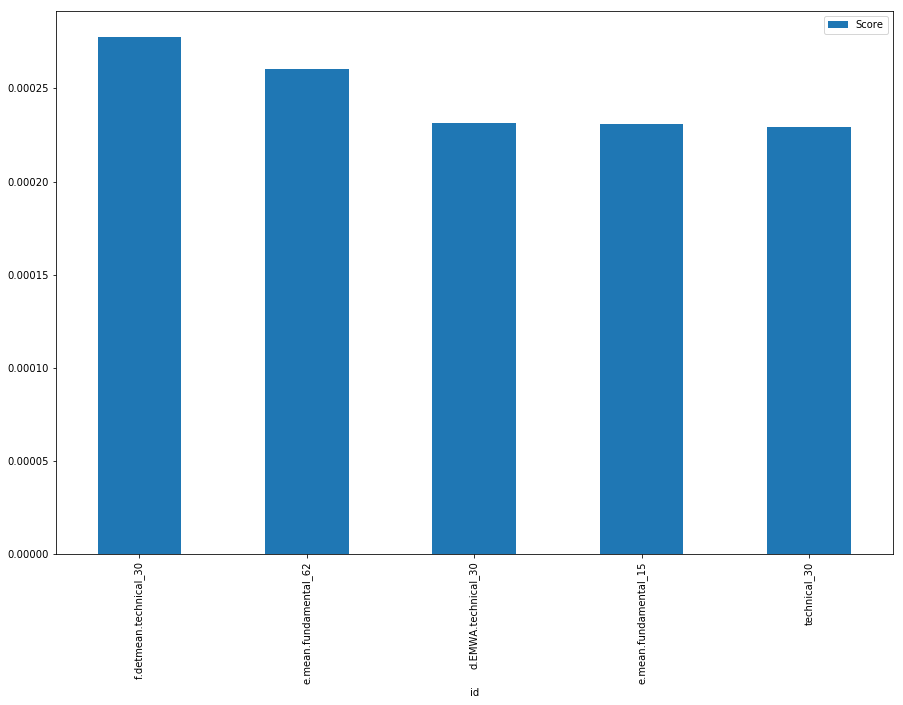

In [345]:
# Step 1: Remove previous feature from searching.
cols.remove('g.deEWMA.technical_20')
# Step 2: Residualize y.
clf = LinearRegression()
clf.fit(ff_frame[['g.deEWMA.technical_20']], ff_frame[['y']])
ff_frame[['y_res1']] = ff_frame[['y']] - clf.predict(ff_frame[['g.deEWMA.technical_20']])
# Step 3: Linear Regression
score1 = linear_reg_score_parallel(ff_frame, cols, "y_res1")
# Step 4: Plot
score1.iloc[0:5].plot(kind = "bar", figsize = (15,10))
print(score1.iloc[0:5])

## The 3rd feature in model I

[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    5.7s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    6.9s
[Parallel(n_jobs=16)]: Done  81 tasks      | elapsed:    8.1s
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    9.6s
[Parallel(n_jobs=16)]: Done 113 tasks      | elapsed:   11.0s
[Parallel(n_jobs=16)]: Done 143 out of 158 | elapsed:   13.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done 158 out of 158 | elapsed:   14.6s finished


                          Score
id                             
e.mean.fundamental_62  0.000261
e.mean.fundamental_15  0.000231
e.mean.fundamental_29  0.000229
e.mean.fundamental_56  0.000211
e.mean.fundamental_60  0.000176


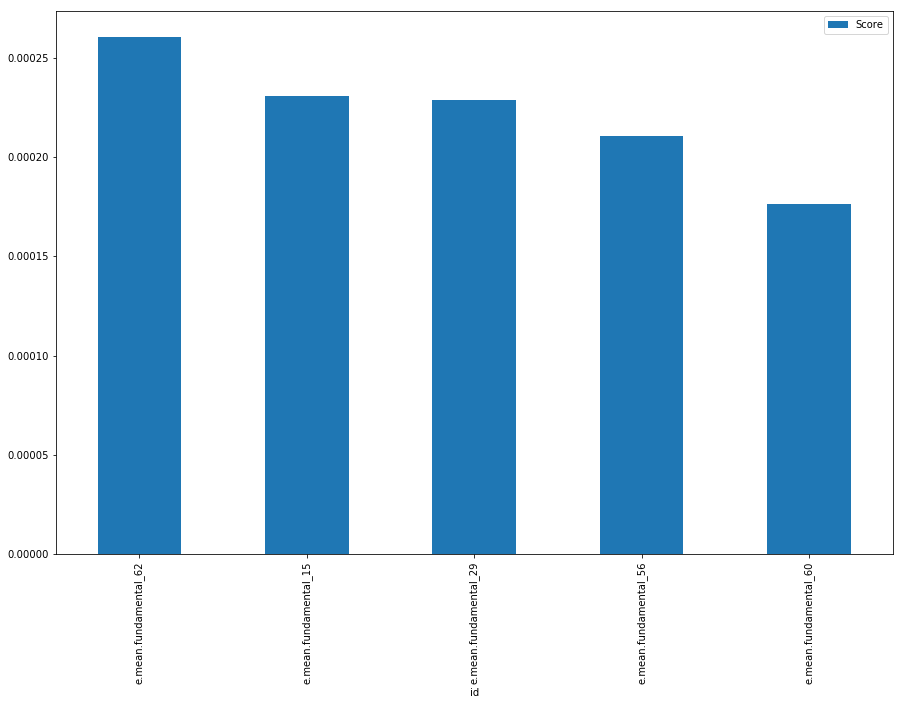

In [346]:
# Step 1: Remove previous feature from searching.
cols.remove('f.detmean.technical_30')
# Step 2: Residualize y. (From the first two regressions)
clf = LinearRegression()
clf.fit(ff_frame[["f.detmean.technical_30", "g.deEWMA.technical_20"]], ff_frame[['y']])
ff_frame[['y_res2']] = ff_frame[['y']] - clf.predict(ff_frame[["f.detmean.technical_30", "g.deEWMA.technical_20"]])
# Step 3: Linear Regression on the rest
score1 = linear_reg_score_parallel(ff_frame, cols, "y_res2")
# Plot result
score1.iloc[0:5].plot(kind = "bar", figsize = (15,10))
print(score1.iloc[0:5])

## The 4th feature in model I

[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    5.4s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    6.6s
[Parallel(n_jobs=16)]: Done  81 tasks      | elapsed:    7.9s
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    9.2s
[Parallel(n_jobs=16)]: Done 113 tasks      | elapsed:   10.7s
[Parallel(n_jobs=16)]: Done 142 out of 157 | elapsed:   13.2s remaining:    1.4s
[Parallel(n_jobs=16)]: Done 157 out of 157 | elapsed:   14.6s finished


                          Score
id                             
e.mean.fundamental_29  0.000400
e.mean.technical_24    0.000163
g.deEWMA.technical_35  0.000159
b.diff.technical_35    0.000148
a.lag_1.technical_20   0.000134


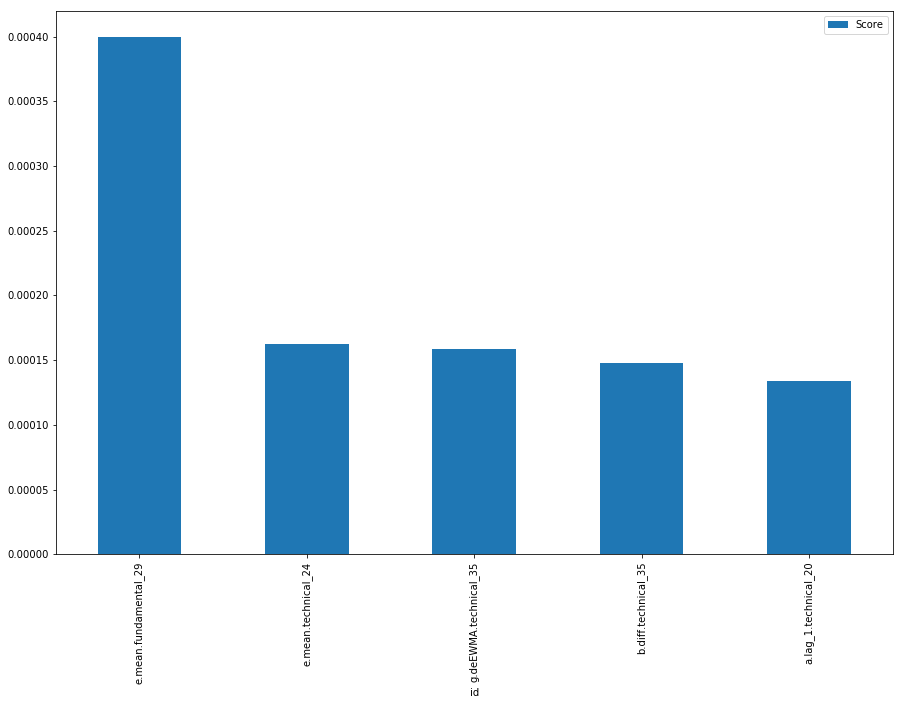

In [104]:
# Step 1: Remove previous feature from searching.
cols.remove('e.mean.fundamental_62')
# Step 2: Residualize y. (From the first two regressions)
clf = LinearRegression()
clf.fit(ff_frame[["f.detmean.technical_30", 
                  "g.deEWMA.technical_20",
                  "e.mean.fundamental_62"]], ff_frame[['y']])
ff_frame[['y_res3']] = ff_frame[['y']] - clf.predict(ff_frame[["f.detmean.technical_30", 
                                                               "g.deEWMA.technical_20",
                                                               "e.mean.fundamental_62"]])
# Step 3: Linear Regression on the rest
score1 = linear_reg_score_parallel(ff_frame, cols, "y_res3")
# Plot result
score1.iloc[0:5].plot(kind = "bar", figsize = (15,10))
print(score1.iloc[0:5])

## The 5th feature in model I

[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    3.1s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.1s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done  81 tasks      | elapsed:    7.7s
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    8.9s
[Parallel(n_jobs=16)]: Done 113 tasks      | elapsed:   10.5s
[Parallel(n_jobs=16)]: Done 141 out of 156 | elapsed:   12.9s remaining:    1.4s
[Parallel(n_jobs=16)]: Done 156 out of 156 | elapsed:   14.0s finished


                          Score
id                             
e.mean.fundamental_56  0.000176
e.mean.fundamental_15  0.000155
e.mean.fundamental_60  0.000147
g.deEWMA.technical_35  0.000122
a.lag_1.technical_20   0.000120


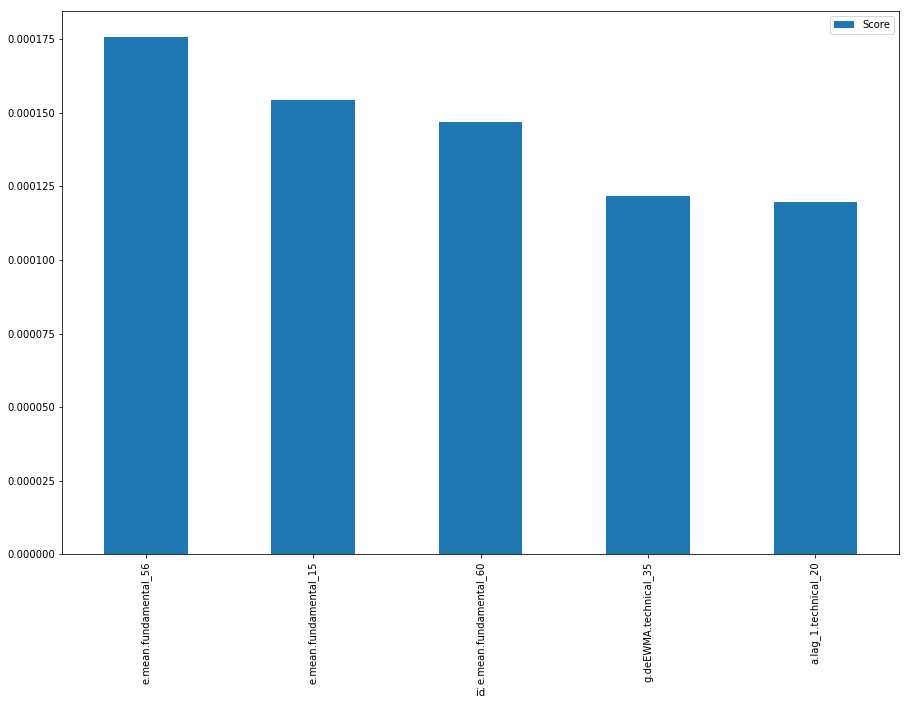

In [105]:
# Step 1: Remove previous feature from searching.
cols.remove("e.mean.fundamental_29")
# Step 2: Residualize y. (From the first two regressions)
clf = LinearRegression()
clf.fit(ff_frame[["e.mean.fundamental_29",
                  "f.detmean.technical_30", 
                  "g.deEWMA.technical_20",
                  "e.mean.fundamental_62"]], ff_frame[['y']])
ff_frame[['y_res4']] = ff_frame[['y']] - clf.predict(ff_frame[["e.mean.fundamental_29",
                                                               "f.detmean.technical_30", 
                                                               "g.deEWMA.technical_20",
                                                               "e.mean.fundamental_62"]])
# Step 3: Linear Regression on the rest
score1 = linear_reg_score_parallel(ff_frame, cols, "y_res4")
# Plot result
score1.iloc[0:5].plot(kind = "bar", figsize = (15,10))
print(score1.iloc[0:5])

In [347]:
model_1_cols = ["e.mean.fundamental_29",
                "f.detmean.technical_30",
                "g.deEWMA.technical_20",
                "e.mean.fundamental_62",
                "e.mean.fundamental_56"]

## Outlier(hist plot)

In [111]:
pipe = Pipeline([("fillna", Imputer(strategy = "median", 
                                    axis=0)),
                 ("preprocessing", Winsorize(lower = 0.05,
                                             higher = 99.95))
                ])
pipe.fit(ff_frame)

tff_frame = pd.DataFrame(pipe.transform(ff_frame))
tff_frame.index = ff_frame.index
tff_frame.columns = ff_frame.columns
res = bench_col_by_col_parallel(ff_frame[model_1_cols], tff_frame[model_1_cols], ff_frame[['y']])
## histplot('/home/xin/data_analysis/notebook/winsor_hist/', filled_train, transformed_train)

[Parallel(n_jobs=16)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.7s
[Parallel(n_jobs=16)]: Done   3 out of   5 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:    1.6s finished


/home/xin/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


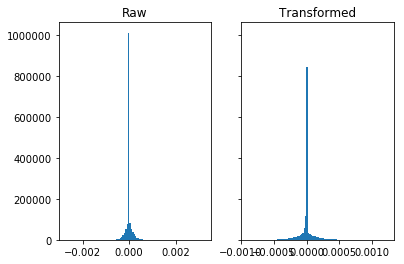

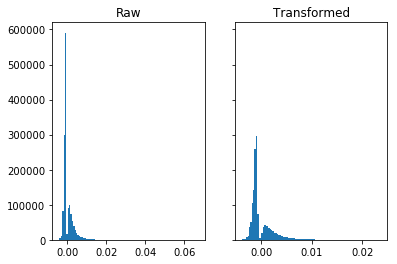

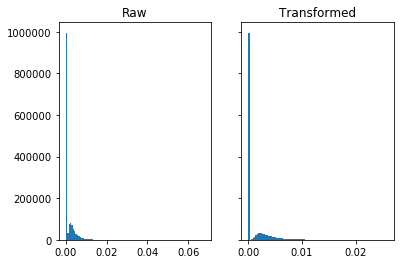

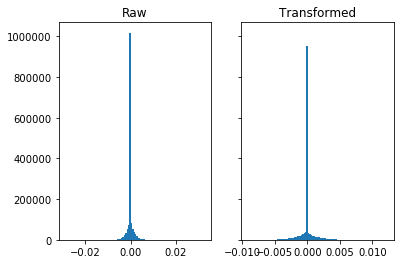

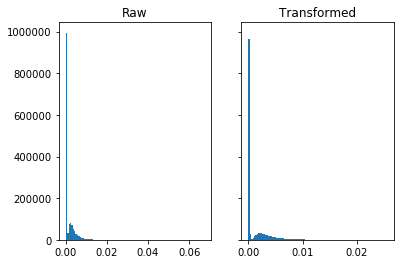

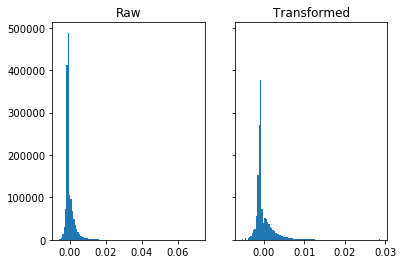

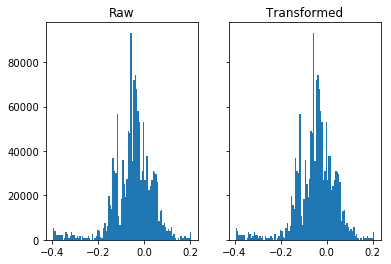

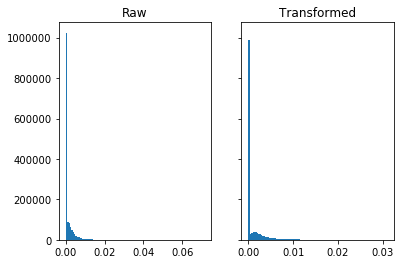

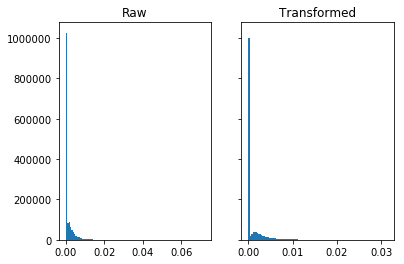

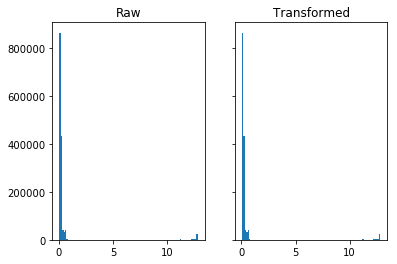

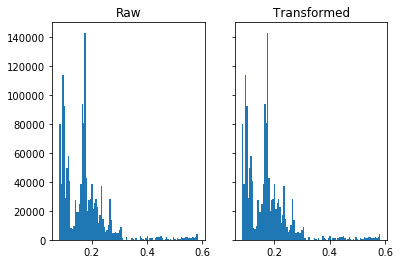

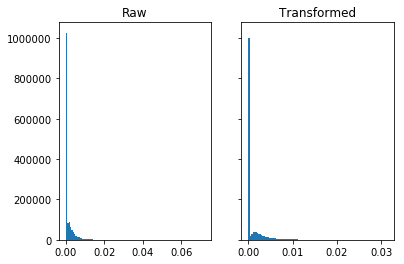

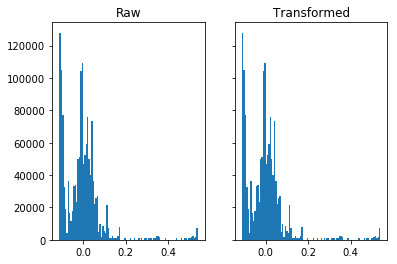

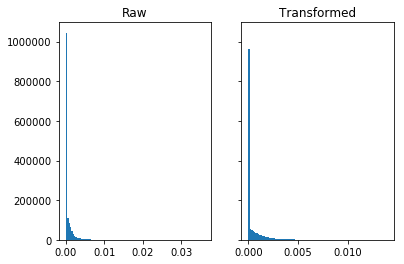

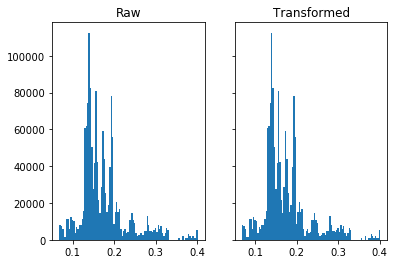

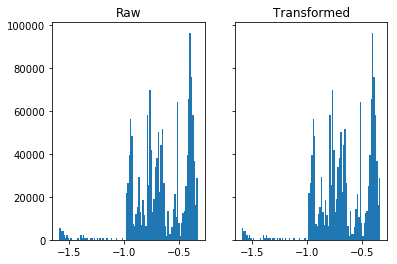

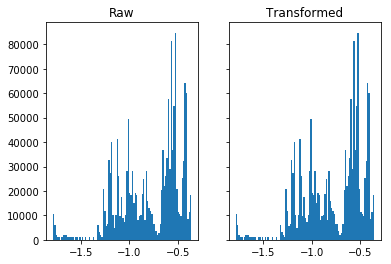

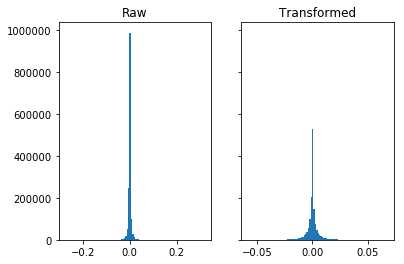

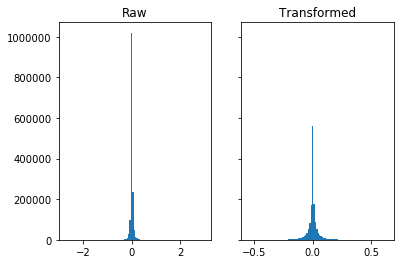

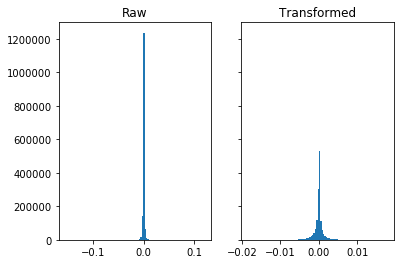

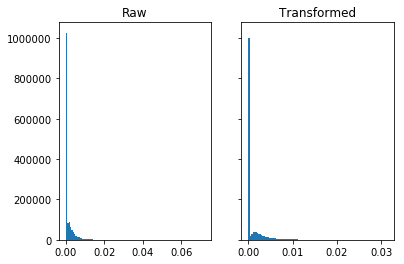

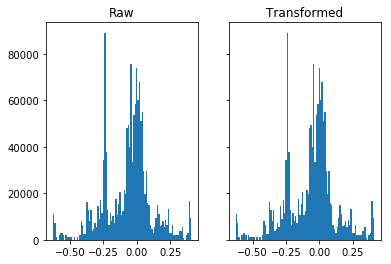

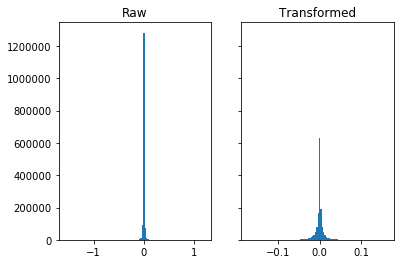

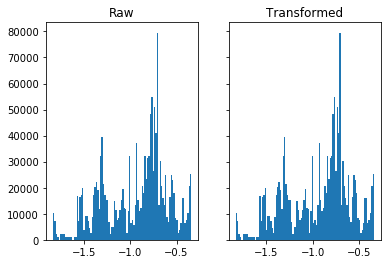

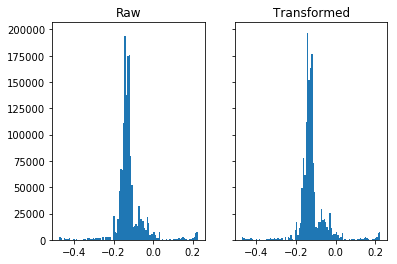

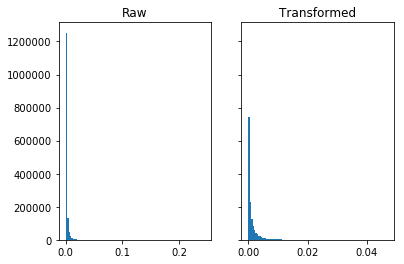

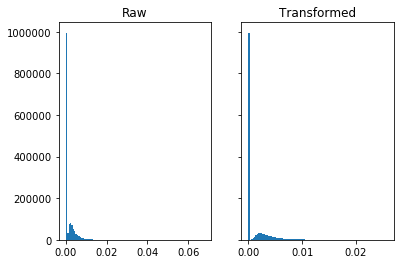

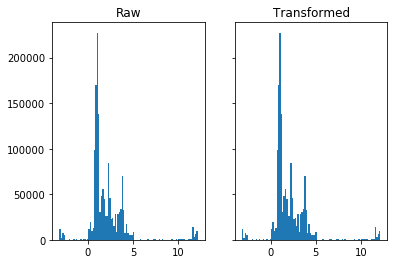

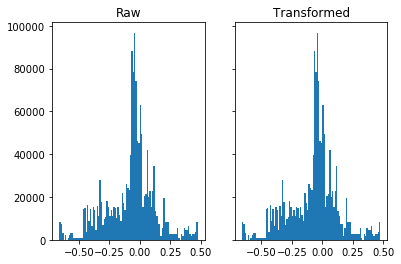

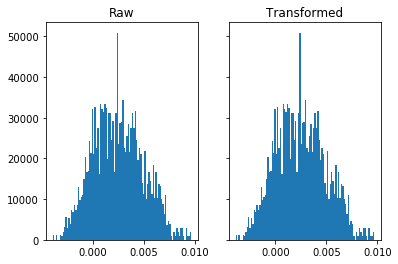

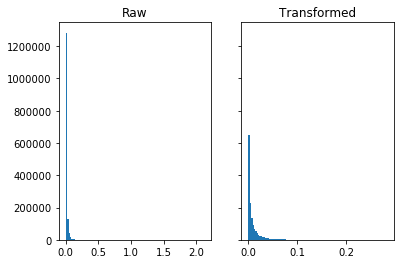

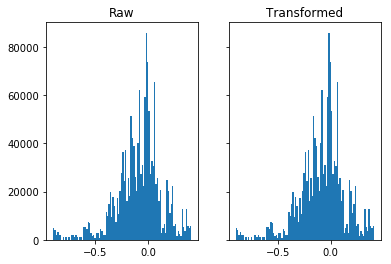

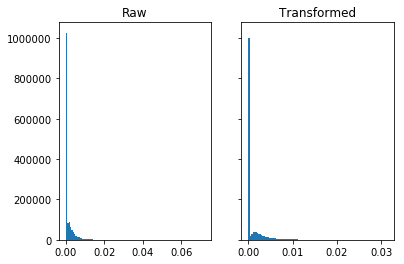

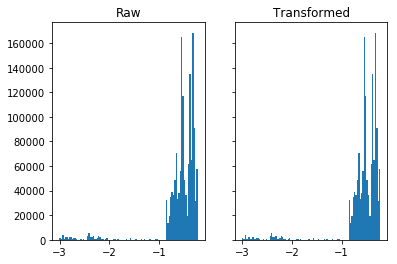

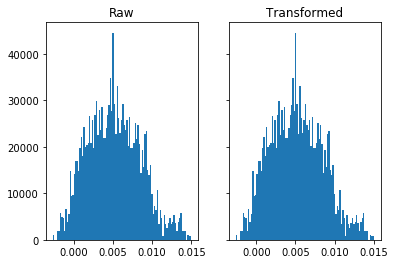

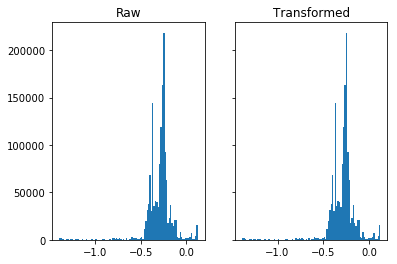

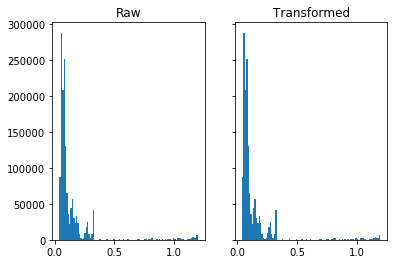

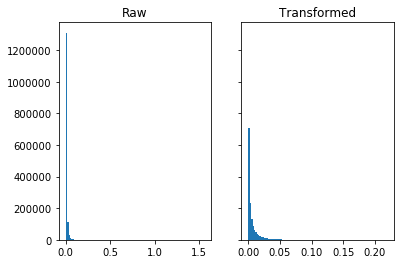

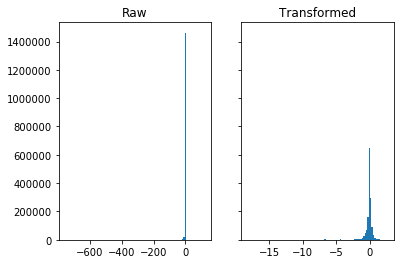

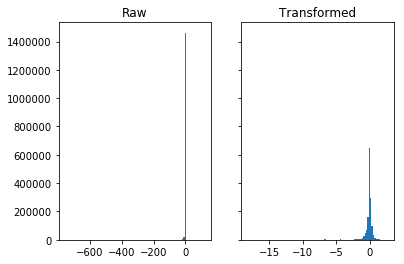

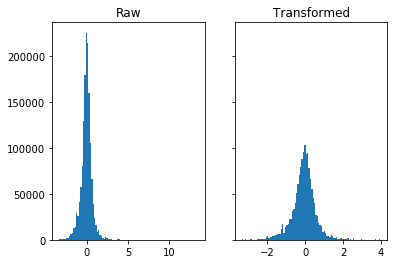

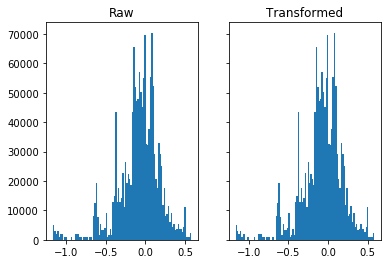

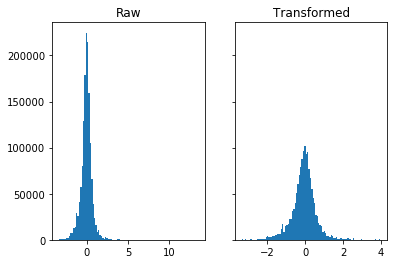

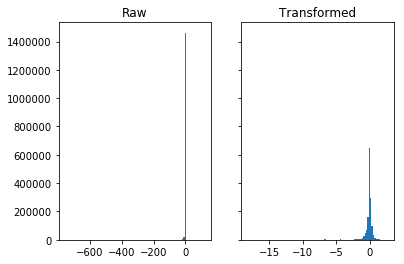

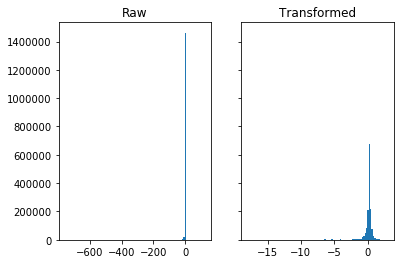

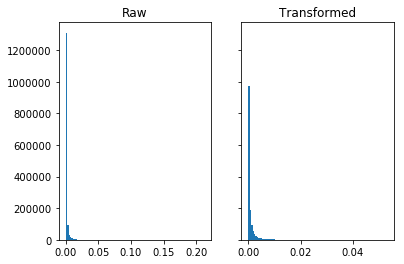

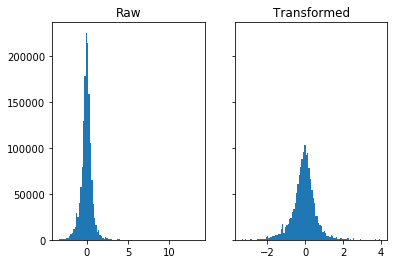

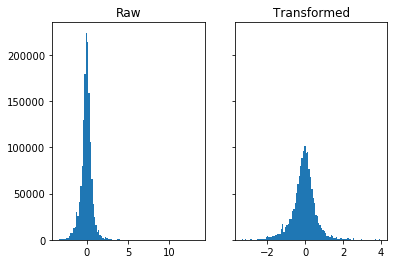

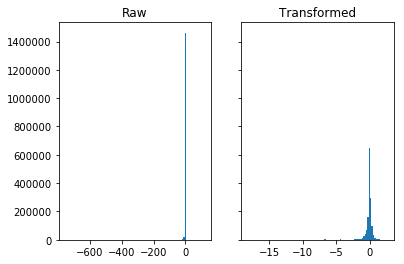

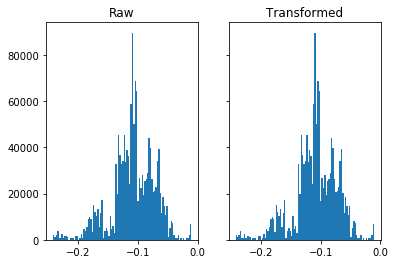

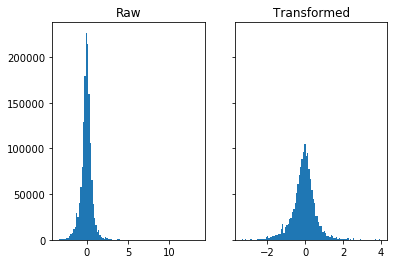

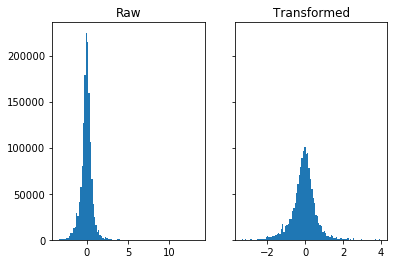

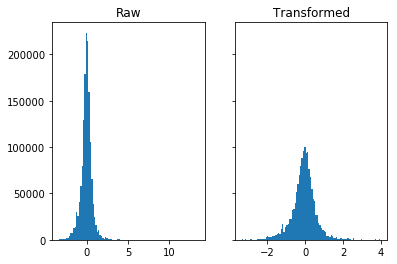

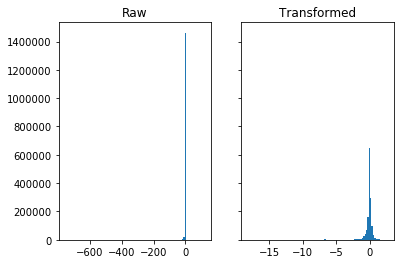

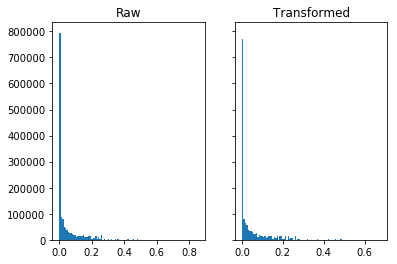

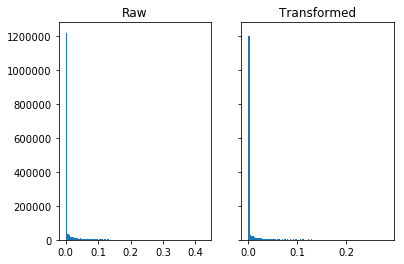

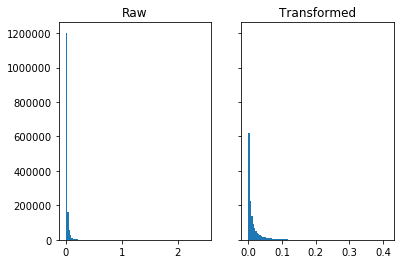

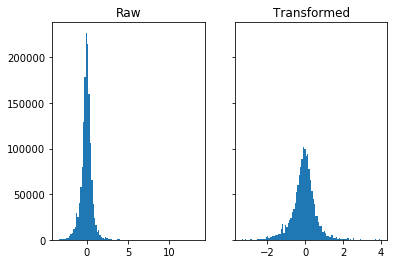

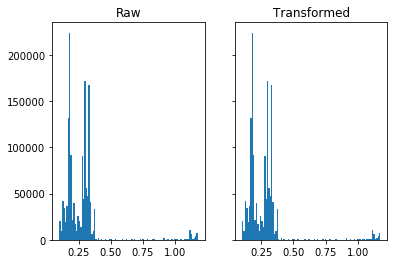

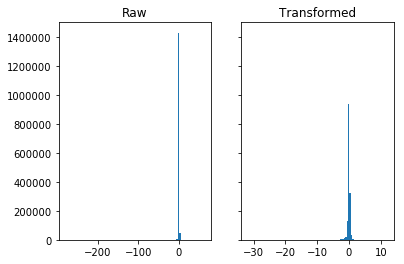

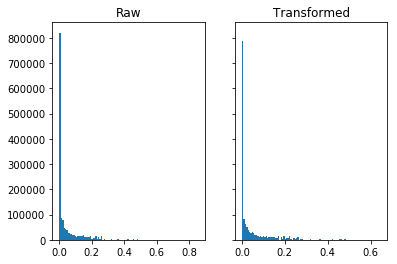

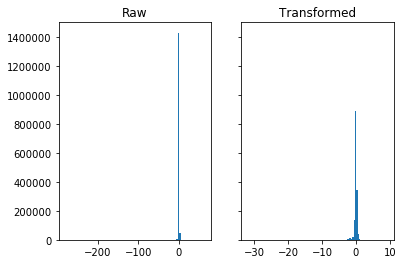

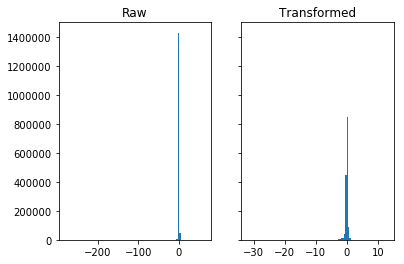

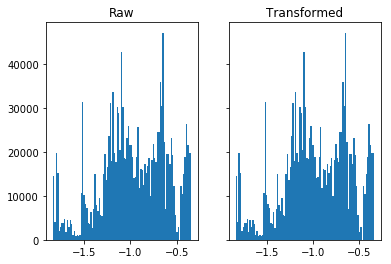

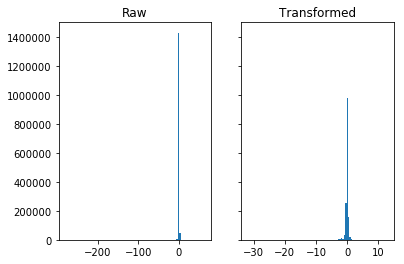

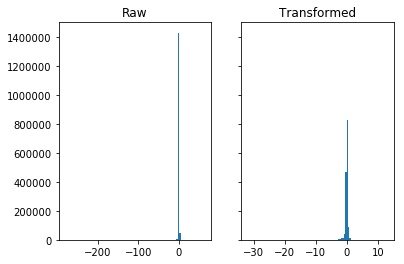

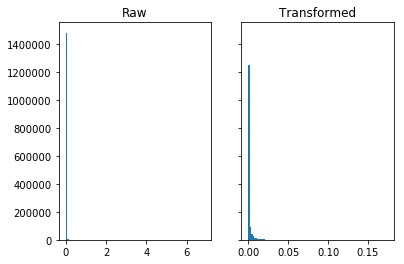

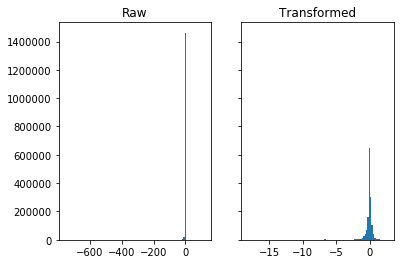

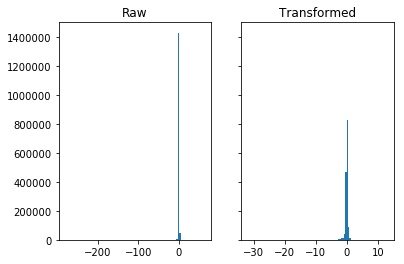

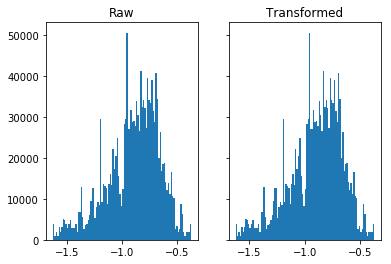

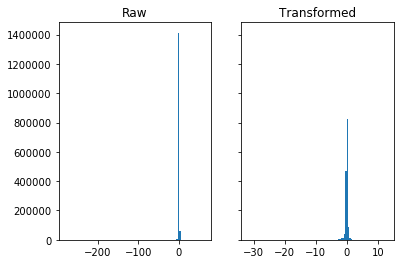

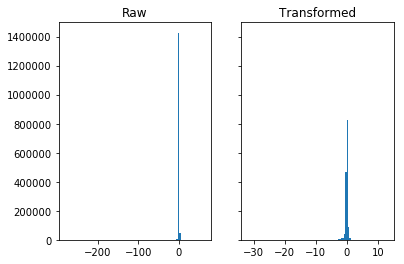

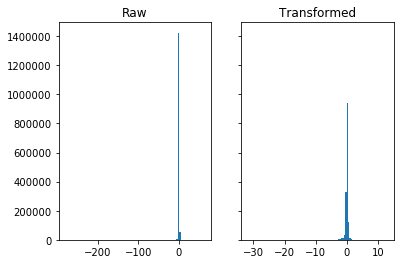

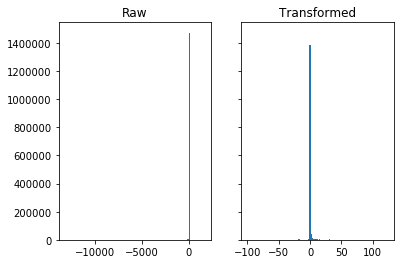

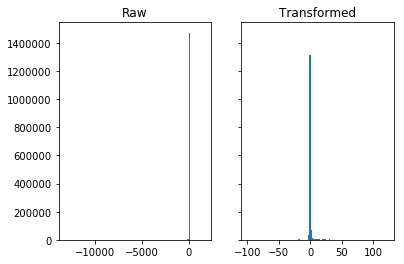

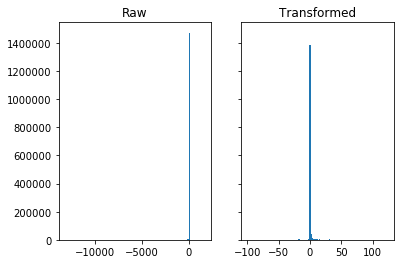

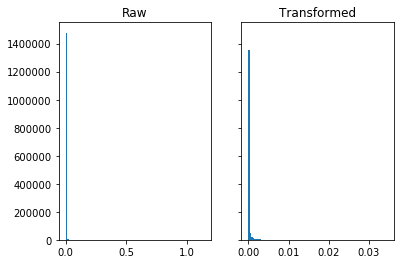

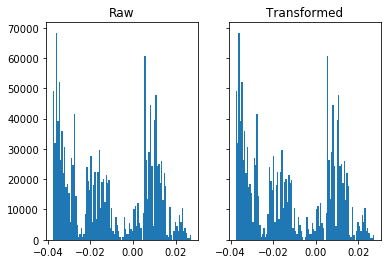

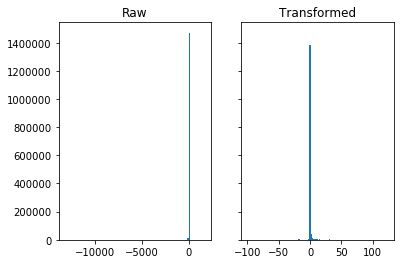

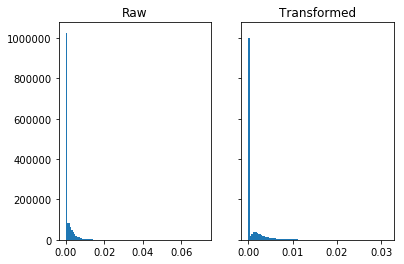

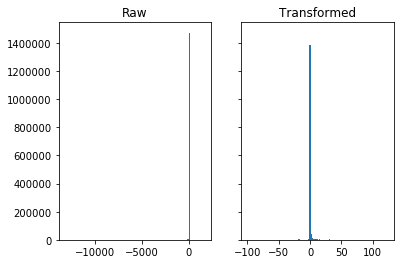

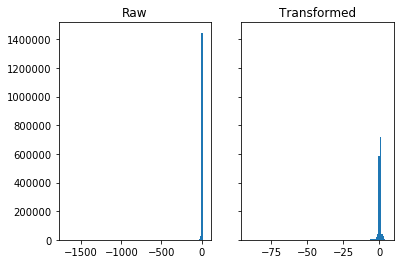

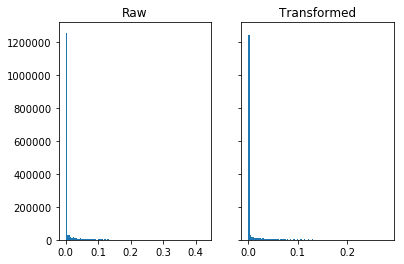

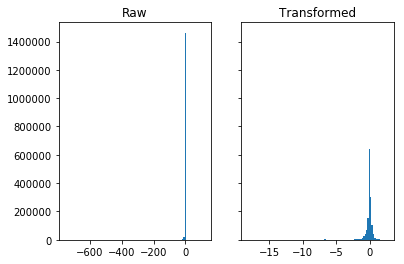

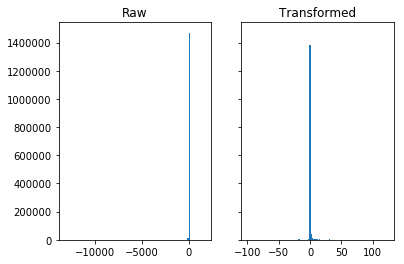

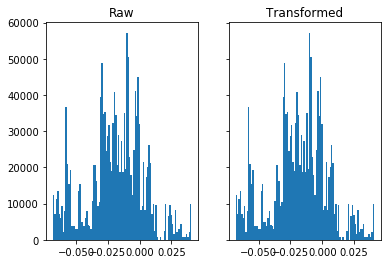

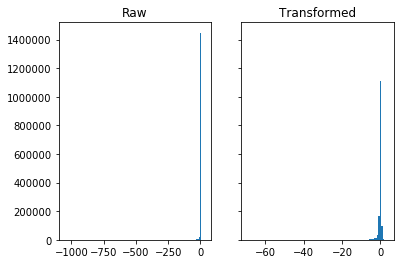

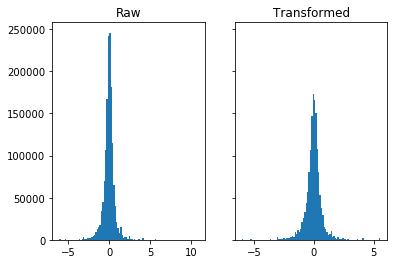

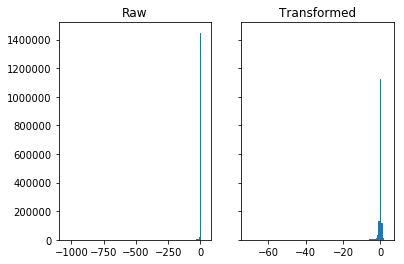

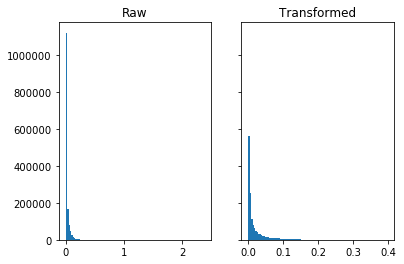

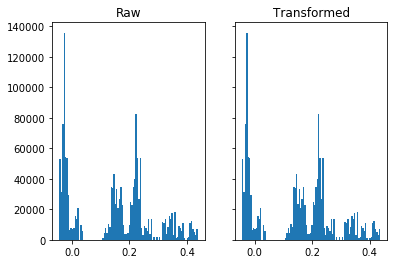

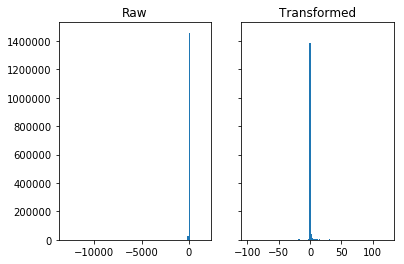

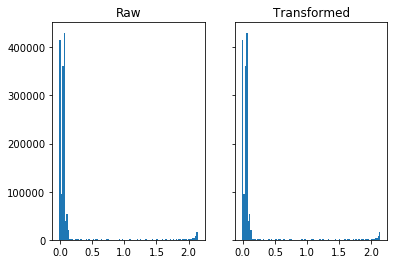

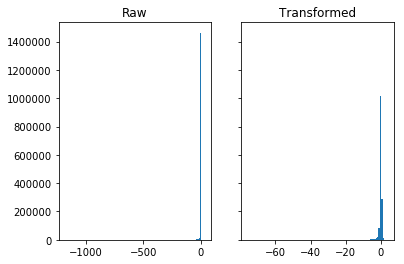

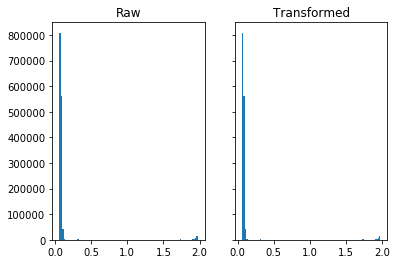

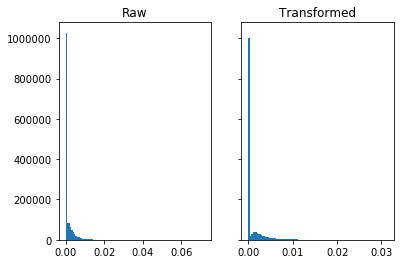

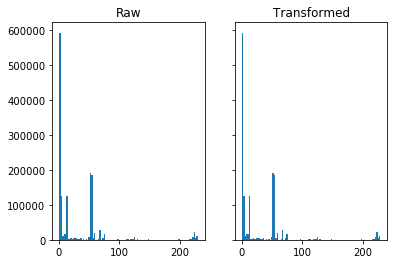

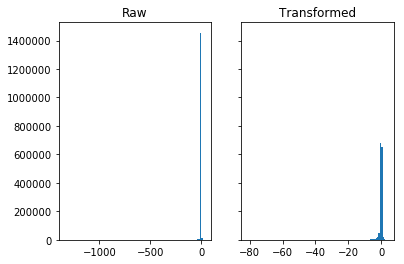

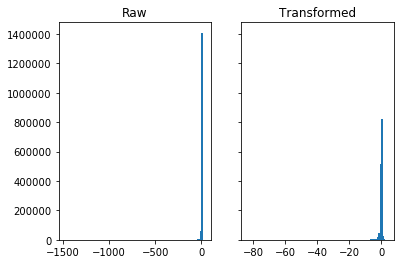

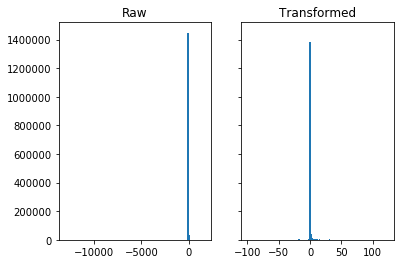

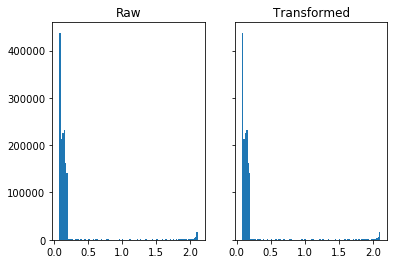

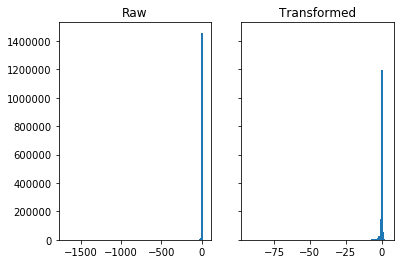

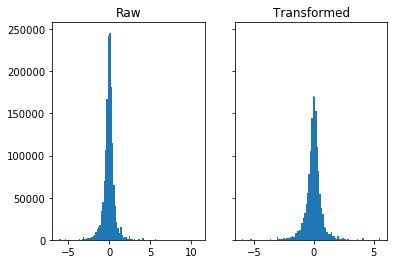

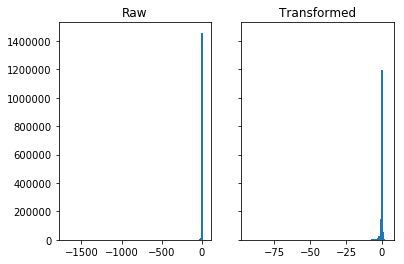

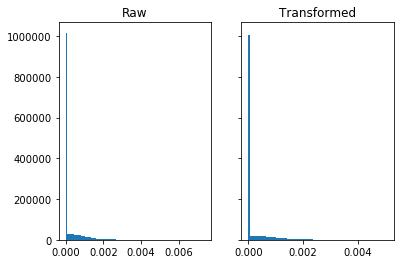

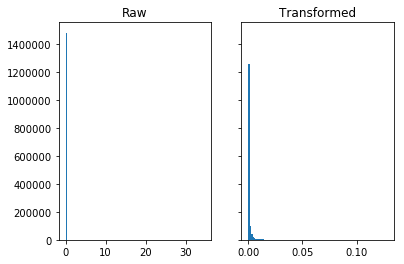

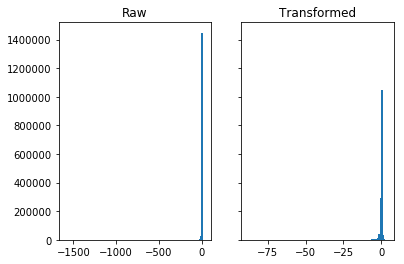

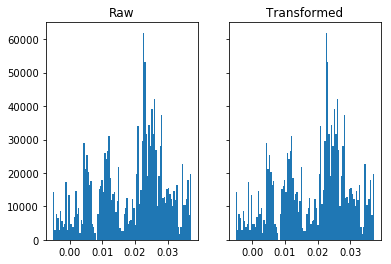

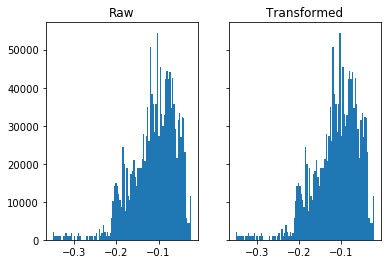

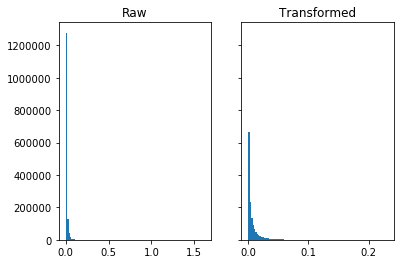

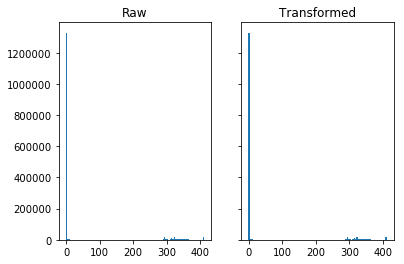

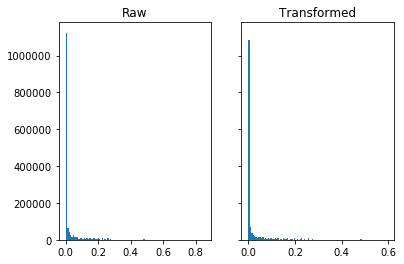

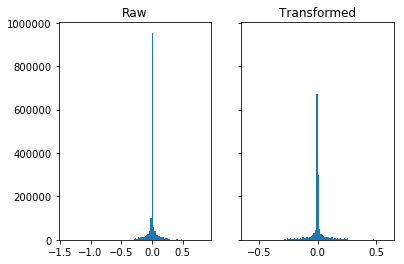

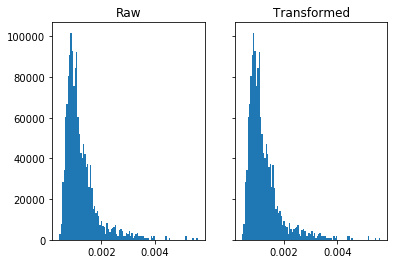

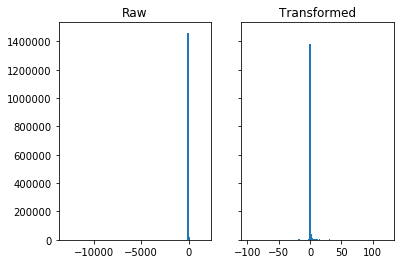

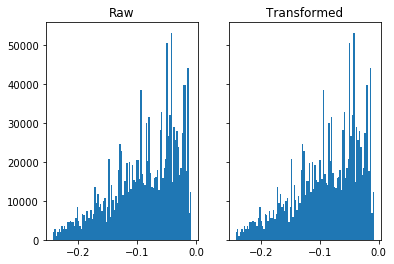

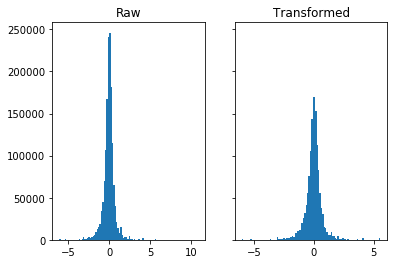

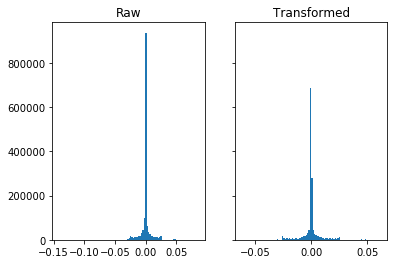

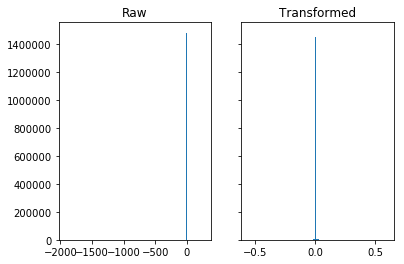

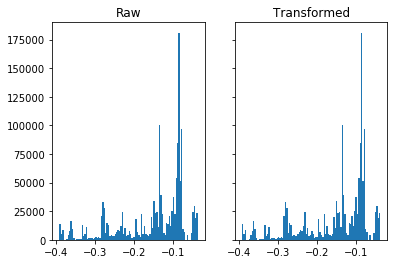

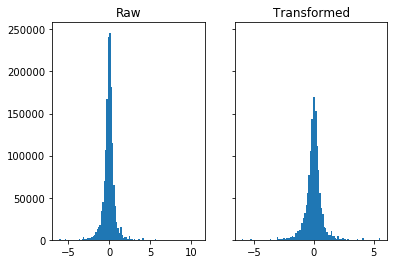

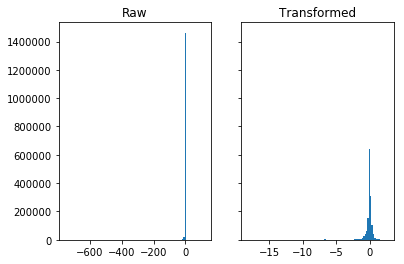

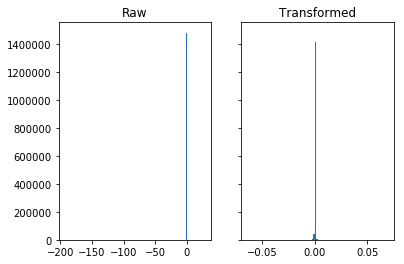

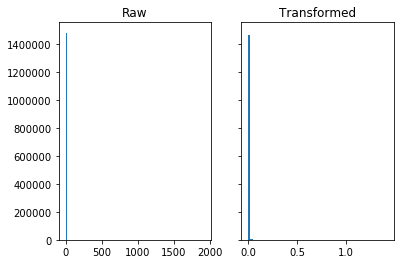

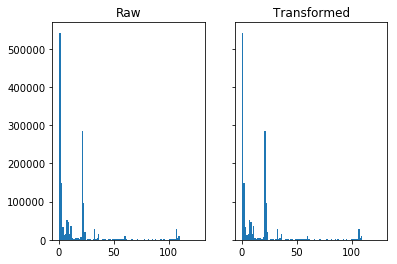

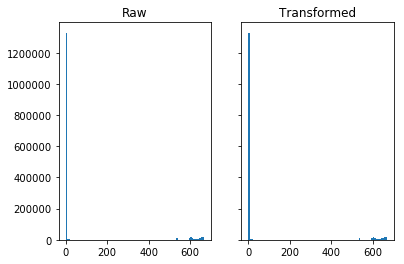

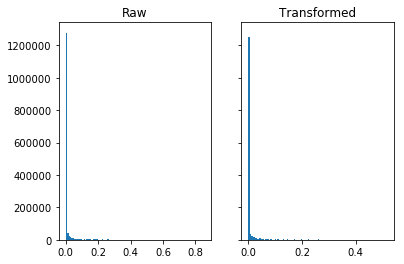

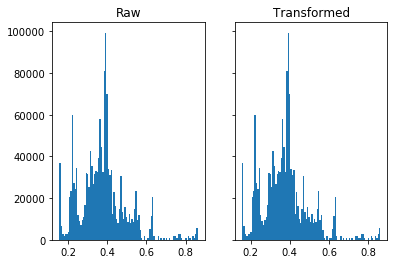

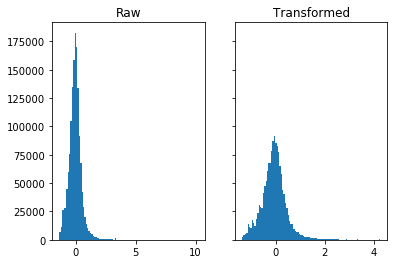

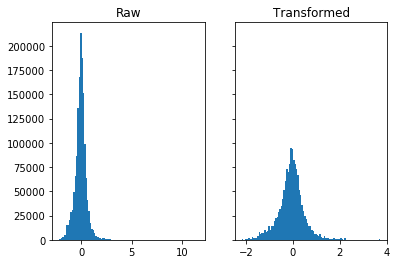

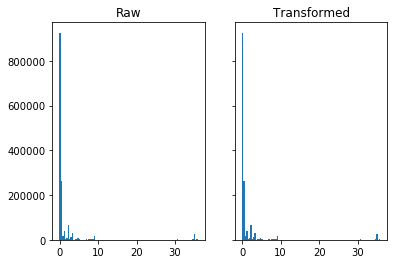

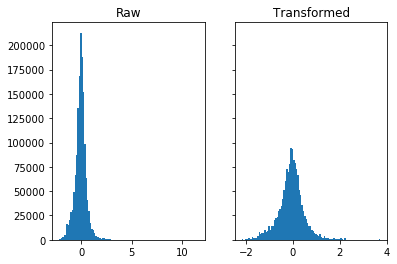

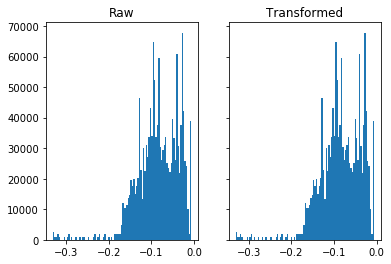

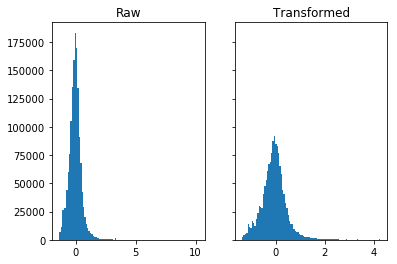

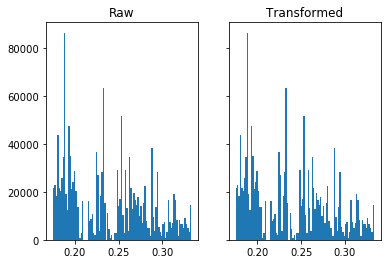

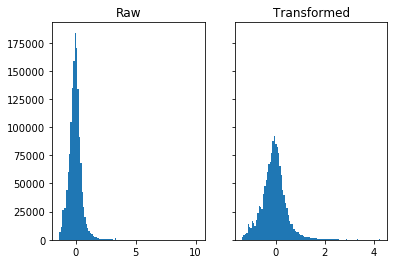

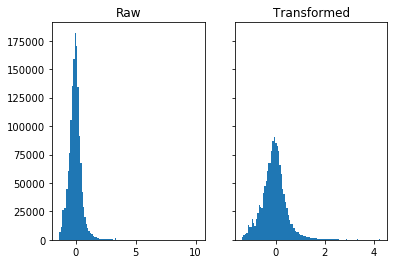

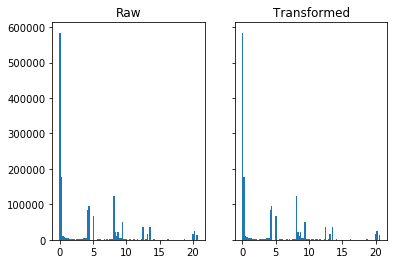

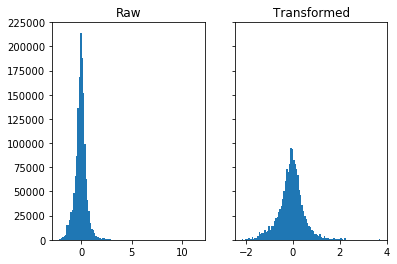

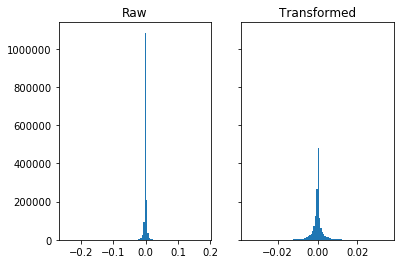

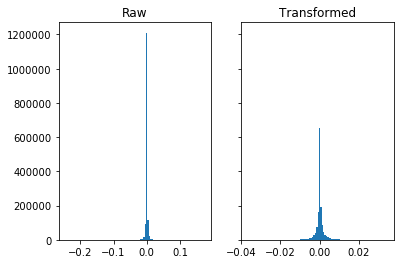

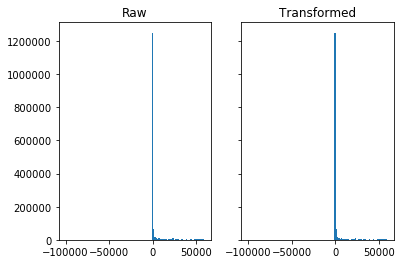

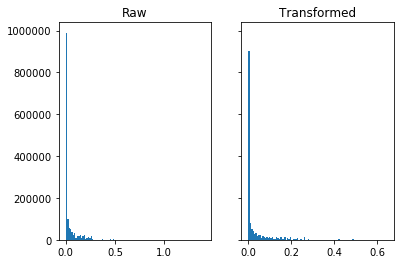

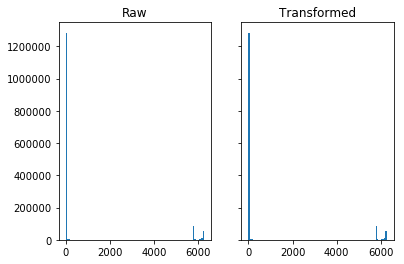

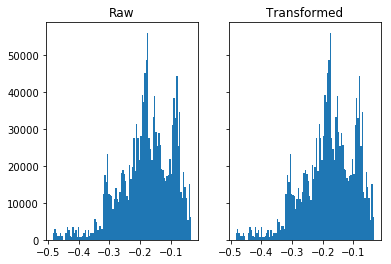

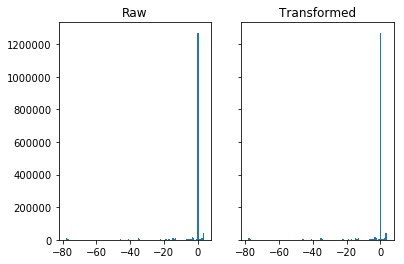

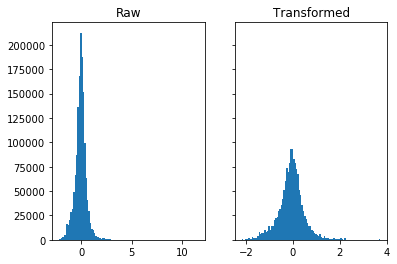

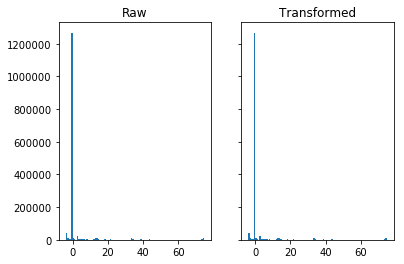

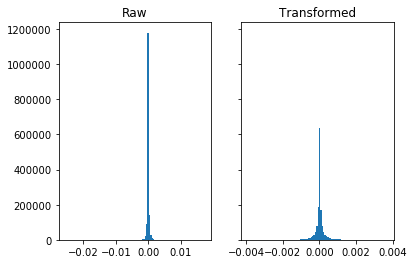

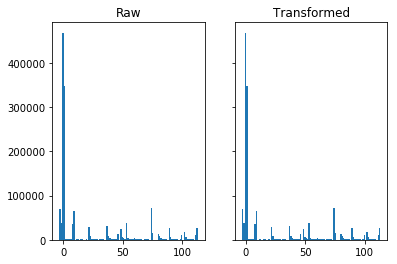

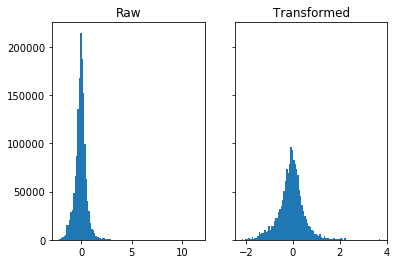

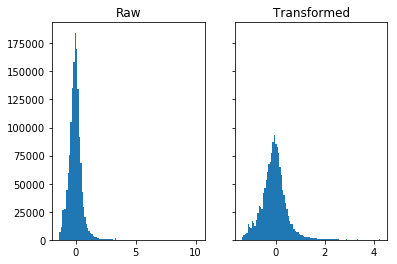

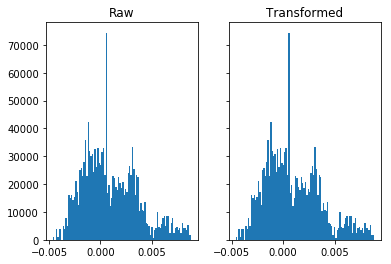

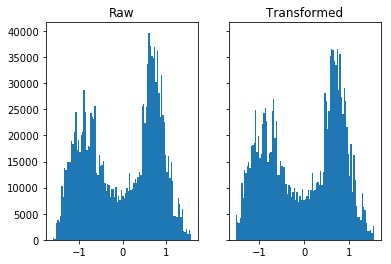

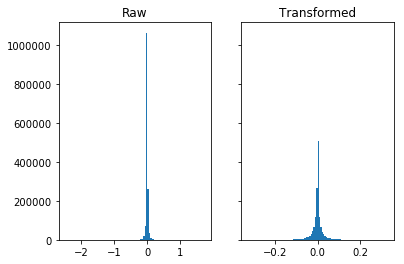

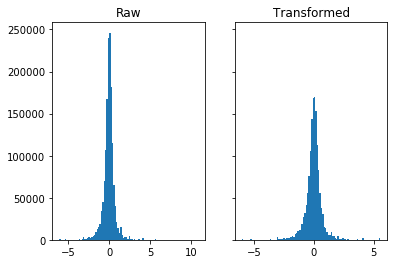

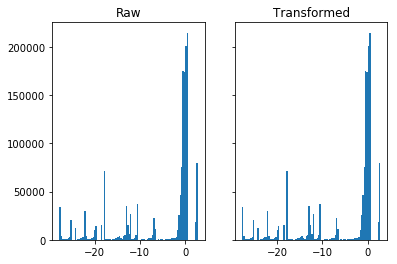

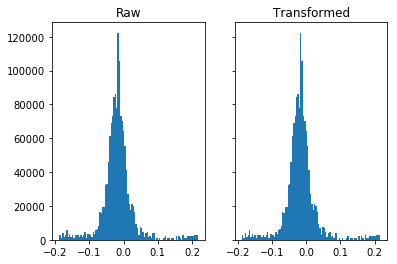

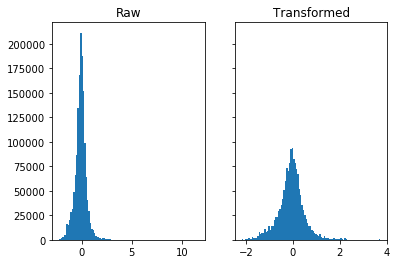

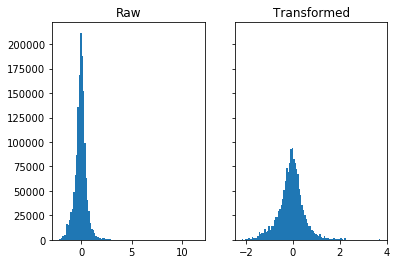

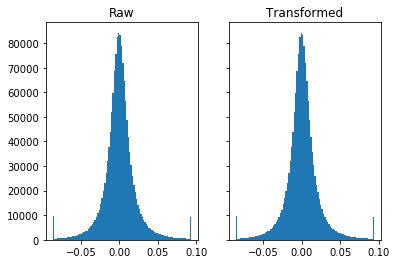

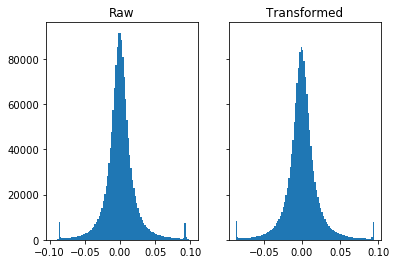

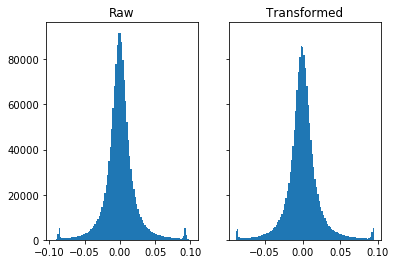

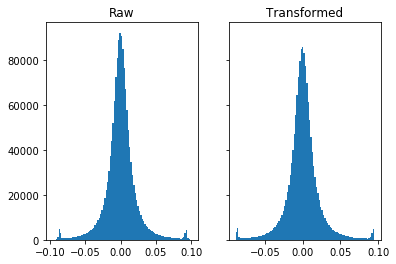

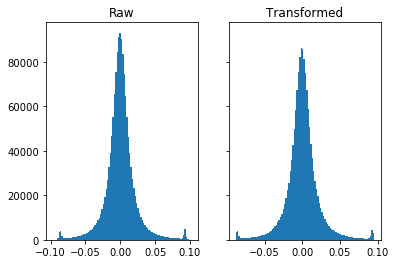

In [114]:
histplot('/home/xin/data_analysis/notebook/winsor_hist/', ff_frame, tff_frame)

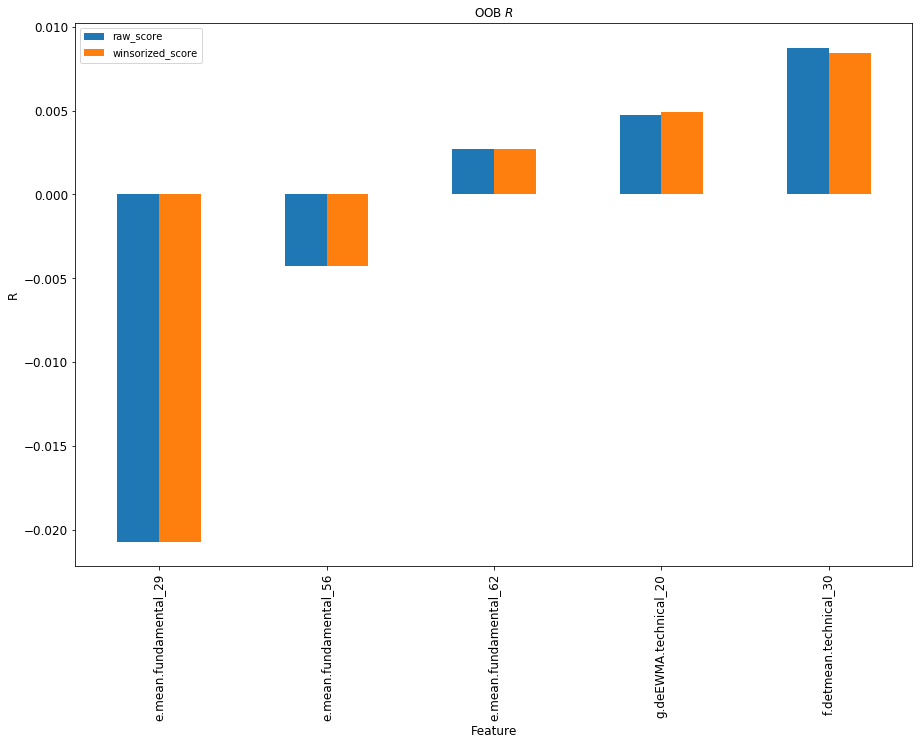

In [115]:
ax = res[['raw_score','winsorized_score']][0:5].plot(kind='bar', title ="OOB $R$", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Feature", fontsize=12)
ax.set_ylabel("R", fontsize=12)
plt.show()

In [348]:
label_feature = ["id", "timestamp", "y"]
model_1_cols = ["e.mean.fundamental_29",
                "f.detmean.technical_30",
                "g.deEWMA.technical_20",
                "e.mean.fundamental_62",
                "e.mean.fundamental_56"]
cols = label_feature + model_1_cols

## Benchmark

In [13]:
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

full_frame = pd.read_pickle("/home/xin/best_params/aug_frame.p")

In [14]:
#correlation.to_pickle("/home/xin/best_params/corr.p")
correlation = pd.read_pickle("/home/xin/best_params/corr.p")
feature = list(correlation.sort_values("y_abs_corr",ascending = False).iloc[0:500, :]["feature"])
label_feature = ["id", "timestamp", "y"]
full_frame = full_frame[feature + label_feature]

In [15]:
timemax = full_frame.timestamp.iloc[-1]

ob_set = full_frame[full_frame.timestamp < 900]

X_train = ob_set[ob_set.timestamp < 900]
y_train = X_train['y']


## Reference Model, plain regression with simple correlation selection

In [35]:
pip0 = Pipeline([("SEL", Selector(list_of_features = ["technical_30", 
                                                     'technical_20',"fundamental_62"])),
                 ("IMP", Imputer(strategy = "median", axis=0)),
                 ("WIN", Winsorize(lower = 5, higher = 95)),
                 ("REG", LinearRegression())
                ])
pip0.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('SEL', Selector(list_of_features=['technical_30', 'technical_20', 'fundamental_62'])), ('IMP', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('WIN', Winsorize(higher=95, lower=5)), ('REG', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [36]:
time_list = []
model0_R_list = []
y_pred_list = []
y_actual_list = []
for time in range(900, timemax):
    if time % 100 == 0:
        gc.collect()
        print(time)
    cur_frame = full_frame[full_frame.timestamp == time]
    
    actual_y = list(cur_frame["y"].values)
    pred_y = list(pip0.predict(cur_frame[feature]))
    
    y_pred_list.extend(pred_y)
    y_actual_list.extend(actual_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    time_list.append(time)
    model0_R_list.append(overall_reward)

900
1000
1100
1200
1300
1400
1500
1600
1700


In [22]:
model_1_cols = ["technical_30",
                "technical_20",
                "f.detmean.technical_30",
                "g.deEWMA.technical_20",
                "e.mean.fundamental_62"]

In [23]:
pip1 = Pipeline([("SEL", Selector(list_of_features = model_1_cols)),
                 ("IMP", Imputer(strategy = "median", axis=0)),
                 ("REG", clip_estimator(clf = ElasticNetCV()))
                ])
pip1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('SEL', Selector(list_of_features=['technical_30', 'technical_20', 'f.detmean.technical_30', 'g.deEWMA.technical_20', 'e.mean.fundamental_62'])), ('IMP', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('REG', clip_estimator(clf=ElasticNetCV(alphas=None, copy_...dom_state=None, selection='cyclic', tol=0.0001, verbose=0),
        high=0.093498, low=-0.0860941))])

In [24]:
time_list = []
model1_train_fh_list = []
y_pred_list = []
y_actual_list = []
for time in range(900, timemax):
    if time % 100 == 0:
        gc.collect()
        print(time)
    cur_frame = full_frame[full_frame.timestamp == time]
    
    actual_y = list(cur_frame["y"].values)
    ob = cur_frame[model_1_cols]
    pred_y = list(pip1.predict(cur_frame[model_1_cols]))
    
    y_pred_list.extend(pred_y)
    y_actual_list.extend(actual_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    time_list.append(time)
    model1_train_fh_list.append(overall_reward)

900
1000
1100
1200
1300
1400
1500
1600
1700


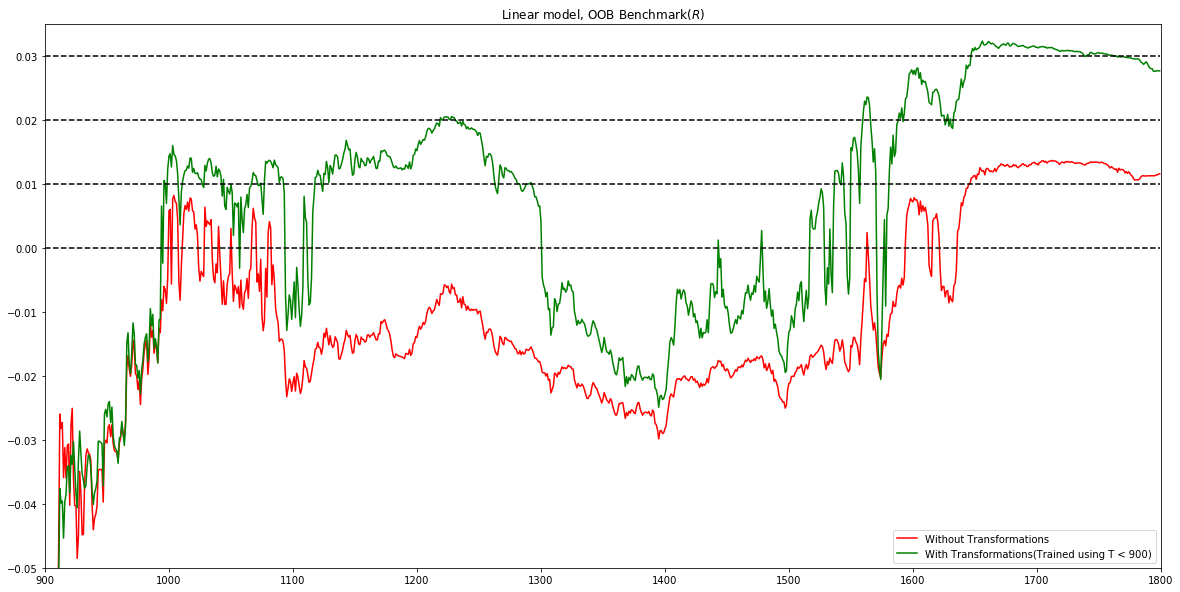

In [40]:
%matplotlib inline
plt.figure(figsize = (20,10))
plt.plot(time_list, model0_R_list, c='red', label = "Without Transformations")
plt.plot(time_list, model1_train_fh_list, c='green', label = "With Transformations(Trained using T < 900)")
plt.plot(time_list, 0.03 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.02 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.01 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.00 + np.zeros(len(time_list)), 'k--')
plt.legend()
plt.xlim([900, 1800])
plt.ylim([-0.05, 0.035])
plt.title("Linear model, OOB Benchmark($R$)")

## Model 2: Random forrest

In [74]:
feature_rf = list(correlation.sort_values("y_abs_corr",ascending = False).iloc[0:80, :]["feature"])
pip1_rf = Pipeline([("SEL", Selector(list_of_features = feature_rf)),
                 ("IMP", Imputer(strategy = "median", axis=0)),
                 ("REG", clip_estimator(clf = RandomForestRegressor(min_samples_split = 2,
                                                                   max_features = 'sqrt',
                                                                   min_samples_leaf = 2,
                                                                   max_depth = 4,
                                                                   n_estimators = 400,
                                                                   n_jobs = 16)))
                ])
pip1_rf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('SEL', Selector(list_of_features=['g.deEWMA.technical_20', 'f.detmean.technical_20', 'technical_20', 'b.diff.technical_20', 'd.EMWA.technical_20', 'f.detmean.technical_30', 'e.mean.fundamental_62', 'd.EMWA.technical_30', 'technical_30', 'e.mean.fundamental_29', 'e.mean.fundamental_15', 'a.la...ore=False, random_state=None, verbose=0, warm_start=False),
        high=0.093498, low=-0.0860941))])

In [75]:
time_list = []
model1_rf = []
y_pred_list = []
y_actual_list = []
for time in range(900, timemax):
    if time % 100 == 0:
        gc.collect()
        print(time)
    cur_frame = full_frame[full_frame.timestamp == time]
    
    actual_y = list(cur_frame["y"].values)
    pred_y = list(pip1_rf.predict(cur_frame))
    
    y_pred_list.extend(pred_y)
    y_actual_list.extend(actual_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    time_list.append(time)
    model1_rf.append(overall_reward)

900
1000
1100
1200
1300
1400
1500
1600
1700


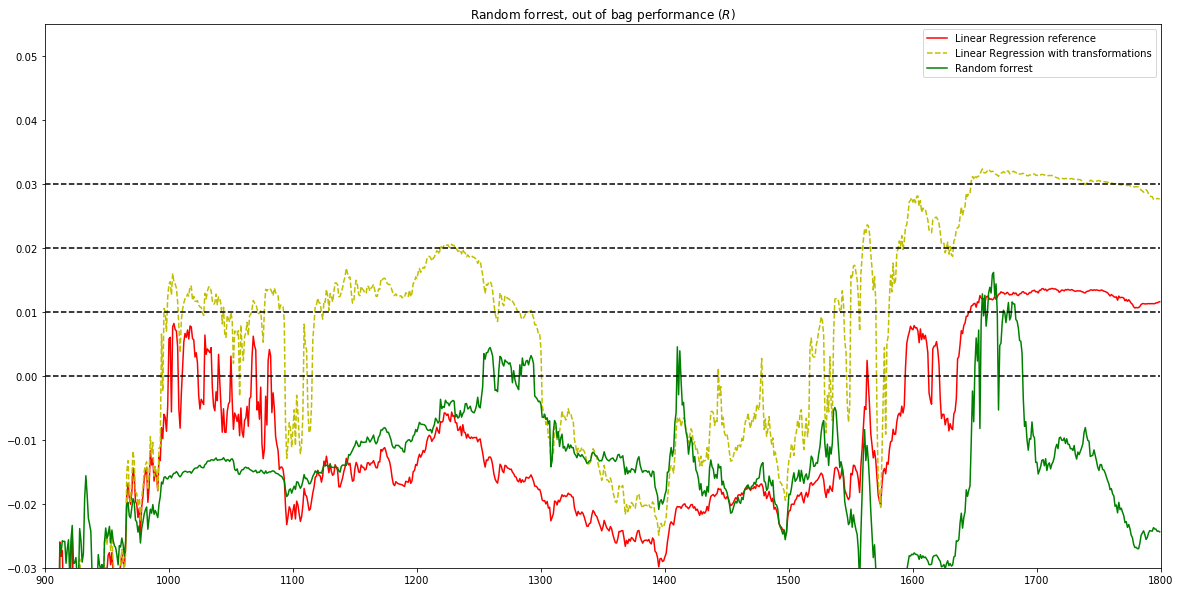

In [79]:
%matplotlib inline
plt.figure(figsize = (20,10))
plt.plot(time_list, model0_R_list, c='red', label = "Linear Regression reference")
plt.plot(time_list, model1_train_fh_list, 'y--', label = "Linear Regression with transformations")
plt.plot(time_list, model1_rf, c='green', label = "Random forrest")
plt.plot(time_list, 0.03 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.02 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.01 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.00 + np.zeros(len(time_list)), 'k--')
plt.legend()
plt.xlim([900, 1800])
plt.ylim([-0.03, 0.055])
plt.title("Random forrest, out of bag performance ($R$)")

## Feature importance

In [80]:
rfclf = RandomForestRegressor(min_samples_split = 2,
                               max_features = 'sqrt',
                               min_samples_leaf = 2,
                               max_depth = 4,
                               n_estimators = 500,
                               n_jobs = 16,
                               oob_score = True)

trans_pipe = Pipeline([("IMP", Imputer(strategy = 'median', axis=0)),
                      ("WIN", Winsorize(lower = 0.01, higher = 99.9))])


rfclf.fit(trans_pipe.fit_transform(X_train[feature_rf]), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=16,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

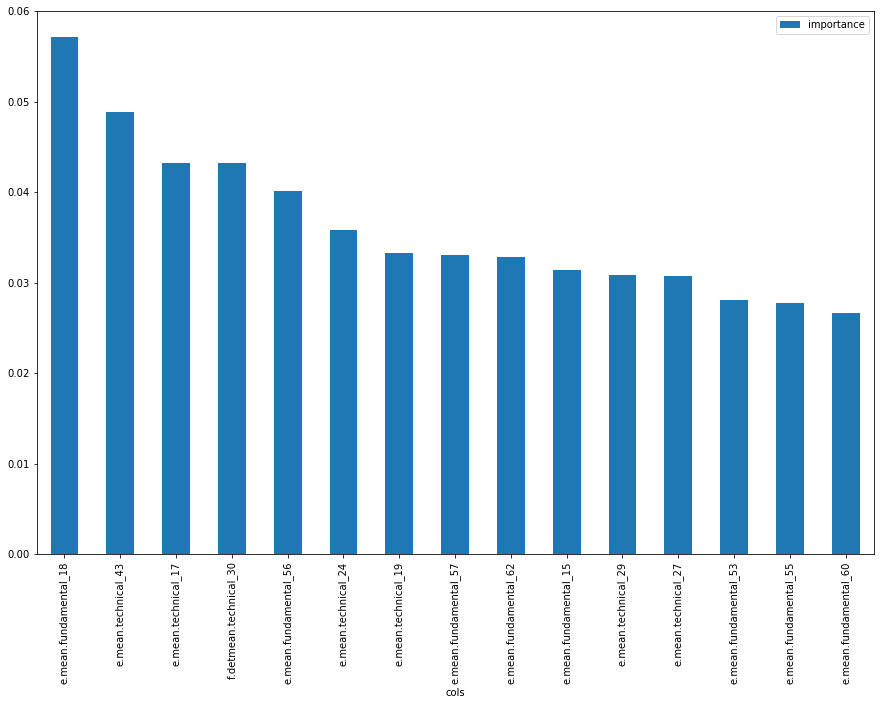

In [83]:
importance = rfclf.feature_importances_
cols = list(X_train[feature_rf].columns)
pd.DataFrame({
        "cols" : cols,
        "importance":importance
    }).set_index("cols").sort_values("importance",ascending = False)[0:15].plot(kind = "bar", figsize = (15,10))

## Model 3: Adaboost

In [194]:
#correlation.to_pickle("/home/xin/best_params/corr.p")
correlation = pd.read_pickle("/home/xin/best_params/corr.p")
feature_rf = list(correlation.sort_values("y_abs_corr",ascending = False).iloc[0:60, :]["feature"])

ada_pipe = Pipeline([("SEL", Selector(list_of_features = feature_rf)),
                    ("IMP", Imputer(axis=0)),
                    ("WIN", Winsorize(lower = 0.01, higher = 99.9)),
                    ("REG", AdaBoostRegressor())
                    ])

ada_param_dist = {
        'IMP__strategy': ["median"],
        'IMP__axis': [0],
        'WIN__lower' : [0.01],
        'WIN__higher' : [99.9],
        'REG__n_estimators' : [10, 20, 30, 50, 100]
}

ada_random_search = RandomizedSearchCV(ada_pipe, 
                                       param_distributions = ada_param_dist, 
                                       verbose = 10, 
                                       n_jobs = 8, n_iter = 5)
ada_random_search.fit(X_train1, y_train1)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator Selector modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator Selector modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator Selector modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator Selector modifies parameters in __init__. This beh

[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=10, IMP__axis=0 
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=10, IMP__axis=0 
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=10, IMP__axis=0 
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=20, IMP__axis=0 
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=20, IMP__axis=0 
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=20, IMP__axis=0 
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=30, IMP__axis=0 
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=30, IMP__axis=0 
[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=10, IMP__axis=0, score=-0.015336534146858094, total=  57.3s
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=30,

[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:  1.0min remaining:  6.5min


[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=10, IMP__axis=0, score=-0.0056429197427740885, total=  58.9s
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=50, IMP__axis=0 
[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=20, IMP__axis=0, score=-0.012318655172243176, total= 1.2min
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=50, IMP__axis=0 


[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:  1.3min remaining:  3.6min


[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=30, IMP__axis=0, score=-0.012318655172243176, total= 1.2min
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=100, IMP__axis=0 
[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=20, IMP__axis=0, score=-0.011313545770849975, total= 1.3min
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=100, IMP__axis=0 


[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:  1.4min remaining:  2.1min


[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=30, IMP__axis=0, score=-0.011313545770849975, total= 1.3min
[CV] IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=100, IMP__axis=0 
[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=20, IMP__axis=0, score=-0.005958928222132176, total= 1.6min


[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:  1.7min remaining:  1.5min


[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=50, IMP__axis=0, score=-0.01344328339975931, total= 1.1min
[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=30, IMP__axis=0, score=-0.005004748218105037, total= 1.2min


[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:  2.2min remaining:  1.1min


[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=50, IMP__axis=0, score=-0.02556385480219725, total= 1.3min
[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=100, IMP__axis=0, score=-0.0268914122941184, total= 1.2min
[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=50, IMP__axis=0, score=0.0004085274857422716, total= 1.2min


[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:  2.6min remaining:   38.3s


[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=100, IMP__axis=0, score=-0.0007392545163933395, total= 1.1min
[CV]  IMP__strategy=median, WIN__lower=0.01, WIN__higher=99.9, REG__n_estimators=100, IMP__axis=0, score=-0.0168041331567248, total= 1.4min


[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:  2.8min finished
/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator Selector modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('SEL', Selector(list_of_features=['g.deEWMA.technical_20', 'f.detmean.technical_20', 'technical_20', 'b.diff.technical_20', 'd.EMWA.technical_20', 'f.detmean.technical_30', 'e.mean.fundamental_62', 'd.EMWA.technical_30', 'technical_30', 'e.mean.fundamental_29', 'e.mean.fundamental_15', 'a.la...ase_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None))]),
          fit_params=None, iid=True, n_iter=5, n_jobs=8,
          param_distributions={'IMP__strategy': ['median'], 'WIN__lower': [0.01], 'WIN__higher': [99.9], 'IMP__axis': [0], 'REG__n_estimators': [10, 20, 30, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [195]:
print(ada_random_search.best_params_)

{'IMP__strategy': 'median', 'WIN__lower': 0.01, 'WIN__higher': 99.9, 'REG__n_estimators': 30, 'IMP__axis': 0}


In [85]:
pip1_ada = Pipeline([("SEL", Selector(list_of_features = feature_rf[0:30])),
                    ("IMP", Imputer(strategy = "median", axis=0)),
                    ("WIN", Winsorize(lower = 0.01, higher = 99.9)),
                     ("REG", clip_estimator(clf = AdaBoostRegressor(n_estimators = 30)))
                ])
pip1_ada.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('SEL', Selector(list_of_features=['g.deEWMA.technical_20', 'f.detmean.technical_20', 'technical_20', 'b.diff.technical_20', 'd.EMWA.technical_20', 'f.detmean.technical_30', 'e.mean.fundamental_62', 'd.EMWA.technical_30', 'technical_30', 'e.mean.fundamental_29', 'e.mean.fundamental_15', 'a.la...oss='linear',
         n_estimators=30, random_state=None),
        high=0.093498, low=-0.0860941))])

In [86]:
time_list = []
model1_ada = []
y_pred_list = []
y_actual_list = []
for time in range(900, timemax):
    if time % 100 == 0:
        gc.collect()
        print(time)
    cur_frame = full_frame[full_frame.timestamp == time]
    
    actual_y = list(cur_frame["y"].values)
    pred_y = list(pip1_ada.predict(cur_frame))
    
    y_pred_list.extend(pred_y)
    y_actual_list.extend(actual_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    time_list.append(time)
    model1_ada.append(overall_reward)

900
1000
1100
1200
1300
1400
1500
1600
1700


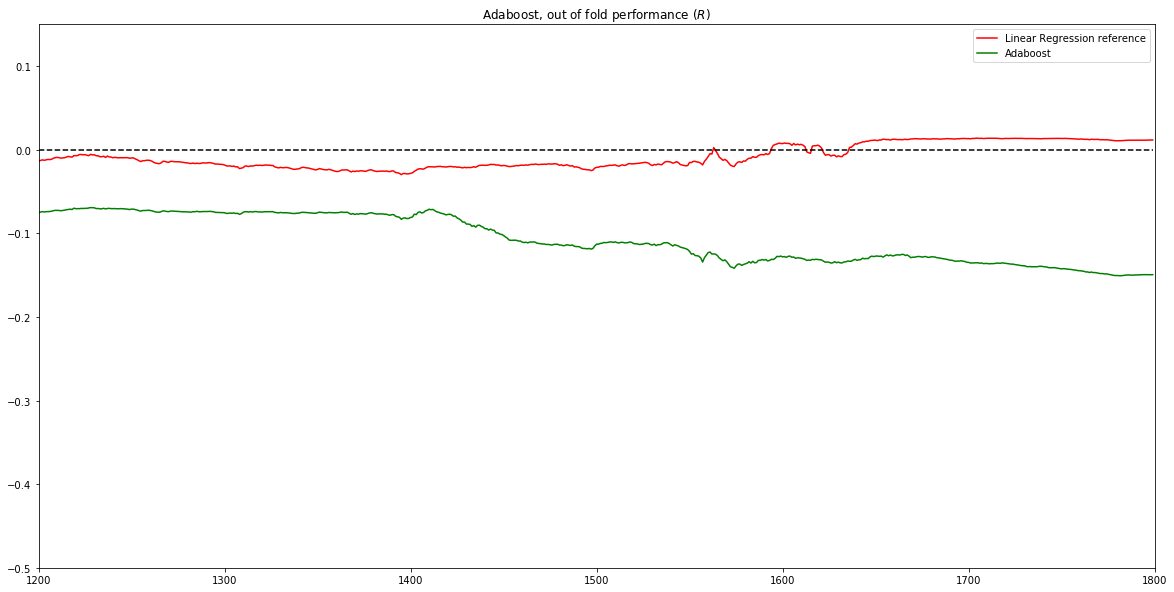

In [90]:
%matplotlib inline
plt.figure(figsize = (20,10))
plt.plot(time_list, model0_R_list, c='red', label = "Linear Regression reference")
plt.plot(time_list, model1_ada, c='green', label = "Adaboost")
plt.plot(time_list, 0.00 + np.zeros(len(time_list)), 'k--')
plt.legend()
plt.xlim([1200, 1800])
plt.ylim([-0.5, 0.15])
plt.title("Adaboost, out of fold performance ($R$)")

we see a miserable oob performance. (As expected for noisy dataset like this.)

## Model 4: Extratree regression

In [221]:
#correlation.to_pickle("/home/xin/best_params/corr.p")
correlation = pd.read_pickle("/home/xin/best_params/corr.p")
feature_rf = list(correlation.sort_values("y_abs_corr",ascending = False).iloc[0:60, :]["feature"])

et_pipe = Pipeline([("IMP", Imputer(strategy = "median", axis=0)),
                    ("WIN", Winsorize()),
                    ("REG", ExtraTreesRegressor())
                    ])

et_param_dist = {
        'REG__n_estimators': [10, 50, 200, 500],
        'REG__max_features': ['auto', 'sqrt','log2'],
        'REG__min_samples_split': [2,3],
        'REG__max_depth': [2, 3, 4, 5, 6, 8, 10],
        'REG__min_samples_leaf': [2,3]
}

et_random_search = RandomizedSearchCV(et_pipe, 
                                       param_distributions = et_param_dist, 
                                       verbose = 10, 
                                       n_jobs = 16, n_iter = 50)

et_random_search.fit(pd.DataFrame(X_train1.fillna(X_train1.median())[feature_rf]), y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=500, REG__min_samples_leaf=3, REG__max_features=auto 
[CV] REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=500, REG__min_samples_leaf=3, REG__max_features=auto 
[CV] REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=500, REG__min_samples_leaf=3, REG__max_features=auto 
[CV] REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=auto 
[CV] REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=auto 
[CV] REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=auto 
[CV] REG__max_depth=5, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto 
[CV] REG__max_depth=5, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf

[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   26.8s


[CV]  REG__max_depth=5, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.0017243759940386294, total=  25.7s
[CV] REG__max_depth=2, REG__min_samples_split=3, REG__n_estimators=500, REG__min_samples_leaf=2, REG__max_features=auto 
[CV]  REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0017851724328052931, total=  11.5s
[CV] REG__max_depth=2, REG__min_samples_split=3, REG__n_estimators=500, REG__min_samples_leaf=2, REG__max_features=auto 
[CV]  REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0014339404609697848, total=  11.8s
[CV] REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=500, REG__min_samples_leaf=2, REG__max_features=auto 
[CV]  REG__max_depth=6, REG__min_samples_split=2, REG__n_estimators=200, REG__min_samples_leaf=3, REG__max_features=sqrt, score=0.00162329908

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  2.3min


[CV]  REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=sqrt, score=-0.0009851319001061842, total=  25.1s
[CV] REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=sqrt 
[CV]  REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=200, REG__min_samples_leaf=3, REG__max_features=auto, score=-0.0007933786377751773, total= 3.1min
[CV] REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=sqrt 
[CV]  REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=200, REG__min_samples_leaf=3, REG__max_features=auto, score=-0.0005199181857165058, total= 3.1min
[CV] REG__max_depth=6, REG__min_samples_split=2, REG__n_estimators=500, REG__min_samples_leaf=3, REG__max_features=auto 
[CV]  REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=sqrt, score=-0.00252011

[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:  5.0min


[CV]  REG__max_depth=2, REG__min_samples_split=3, REG__n_estimators=500, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.00019745871453569208, total= 4.6min
[CV] REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=500, REG__min_samples_leaf=3, REG__max_features=log2 
[CV]  REG__max_depth=2, REG__min_samples_split=3, REG__n_estimators=500, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.002323901668719319, total= 4.7min
[CV] REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=500, REG__min_samples_leaf=3, REG__max_features=log2 
[CV]  REG__max_depth=8, REG__min_samples_split=2, REG__n_estimators=500, REG__min_samples_leaf=2, REG__max_features=sqrt, score=3.1442936115344544e-05, total= 2.1min
[CV] REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=500, REG__min_samples_leaf=3, REG__max_features=log2 
[CV]  REG__max_depth=4, REG__min_samples_split=2, REG__n_estimators=500, REG__min_samples_leaf=2, REG__max_features=sqrt, score=-0.00145789

[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:  6.4min


[CV]  REG__max_depth=3, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=sqrt, score=-0.0009038569478807545, total=   8.5s
[CV] REG__max_depth=3, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=sqrt 
[CV]  REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=500, REG__min_samples_leaf=3, REG__max_features=log2, score=-0.0009619283173880611, total=  48.2s
[CV] REG__max_depth=6, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=sqrt 
[CV]  REG__max_depth=8, REG__min_samples_split=2, REG__n_estimators=500, REG__min_samples_leaf=2, REG__max_features=sqrt, score=-0.001681002105205609, total= 2.7min
[CV] REG__max_depth=6, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=sqrt 
[CV]  REG__max_depth=3, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=sqrt, score=-0.00116921459256

[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:  7.0min


[CV]  REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=sqrt, score=-0.0011115919868518453, total=   9.5s
[CV] REG__max_depth=2, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=3, REG__max_features=sqrt 
[CV]  REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=sqrt, score=-0.0015042816782722124, total=  10.6s
[CV] REG__max_depth=2, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=3, REG__max_features=sqrt 
[CV]  REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=200, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0015394370369521404, total=  23.2s
[CV] REG__max_depth=2, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=3, REG__max_features=sqrt 
[CV]  REG__max_depth=2, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=3, REG__max_features=sqrt, score=0.000280809680478

[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:  7.7min


[CV]  REG__max_depth=8, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0009684189354046691, total=  14.1s
[CV] REG__max_depth=6, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=log2 
[CV]  REG__max_depth=8, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.002890485810457033, total=  16.4s
[CV] REG__max_depth=6, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=log2 
[CV]  REG__max_depth=6, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=log2, score=-0.002808509654132374, total=   9.8s
[CV] REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=200, REG__min_samples_leaf=2, REG__max_features=log2 
[CV]  REG__max_depth=6, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=log2, score=-0.002283616742838

[Parallel(n_jobs=16)]: Done  81 tasks      | elapsed:  9.2min


[CV]  REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0012484145890911957, total=   7.9s
[CV] REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=log2 
[CV]  REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0011956311298511046, total=   7.7s
[CV] REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=log2 
[CV]  REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0008173151373958021, total=   7.8s
[CV] REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=auto 
[CV]  REG__max_depth=4, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.003130177633140

[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed: 15.2min


[CV]  REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.0035946079133981623, total=  12.5s
[CV] REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto 
[CV]  REG__max_depth=8, REG__min_samples_split=3, REG__n_estimators=200, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.003433726265797521, total= 6.3min
[CV] REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto 
[CV]  REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.0024403096561400606, total=  12.0s
[CV] REG__max_depth=3, REG__min_samples_split=2, REG__n_estimators=200, REG__min_samples_leaf=2, REG__max_features=log2 
[CV]  REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.00037297815218

[Parallel(n_jobs=16)]: Done 113 tasks      | elapsed: 16.8min


[CV]  REG__max_depth=5, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.0032444622109206733, total=  20.5s
[CV] REG__max_depth=5, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=sqrt 
[CV]  REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=log2, score=-0.001329153796517879, total=   9.9s
[CV] REG__max_depth=5, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=sqrt 
[CV]  REG__max_depth=5, REG__min_samples_split=3, REG__n_estimators=10, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.005622035386810609, total=  22.6s
[CV] REG__max_depth=5, REG__min_samples_split=3, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=sqrt 
[CV]  REG__max_depth=2, REG__min_samples_split=2, REG__n_estimators=10, REG__min_samples_leaf=3, REG__max_features=log2, score=-0.00097362559818137

[Parallel(n_jobs=16)]: Done 135 out of 150 | elapsed: 18.2min remaining:  2.0min


[CV]  REG__max_depth=3, REG__min_samples_split=3, REG__n_estimators=200, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0007659845708649637, total=  21.8s
[CV]  REG__max_depth=6, REG__min_samples_split=3, REG__n_estimators=200, REG__min_samples_leaf=2, REG__max_features=log2, score=0.00029097087402263355, total=  27.4s
[CV]  REG__max_depth=6, REG__min_samples_split=3, REG__n_estimators=200, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.00229768876359171, total=  26.8s
[CV]  REG__max_depth=6, REG__min_samples_split=3, REG__n_estimators=200, REG__min_samples_leaf=2, REG__max_features=log2, score=-0.0013905269962215527, total=  32.4s
[CV]  REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.01531473359836144, total= 1.6min
[CV]  REG__max_depth=10, REG__min_samples_split=2, REG__n_estimators=50, REG__min_samples_leaf=2, REG__max_features=auto, score=-0.00851909616151425, total= 1.7min
[CV]  REG_

[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed: 20.6min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('IMP', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('WIN', Winsorize(higher=99.9, lower=0.01)), ('REG', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrea...stimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=50, n_jobs=16,
          param_distributions={'REG__max_depth': [2, 3, 4, 5, 6, 8, 10], 'REG__min_samples_split': [2, 3], 'REG__min_samples_leaf': [2, 3], 'REG__max_features': ['auto', 'sqrt', 'log2'], 'REG__n_estimators': [10, 50, 200, 500]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [224]:
print(et_random_search.best_params_)

{'REG__max_depth': 3, 'REG__min_samples_split': 3, 'REG__min_samples_leaf': 3, 'REG__n_estimators': 10, 'REG__max_features': 'sqrt'}


In [119]:
pip1_et = Pipeline([("SEL", Selector(list_of_features = feature_rf[0:30])),
                    ("IMP", Imputer(strategy = "median", axis=0)),
                    ("WIN", Winsorize(lower = 0.01, higher = 99.9)),
                     ("REG", clip_estimator(clf = ExtraTreesRegressor(max_depth = 3,
                                                                     min_samples_split = 3,
                                                                     min_samples_leaf = 3,
                                                                     n_estimators = 30,
                                                                     max_features = 'sqrt',
                                                                     n_jobs = 16)))
                ])
pip1_et.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('SEL', Selector(list_of_features=['g.deEWMA.technical_20', 'f.detmean.technical_20', 'technical_20', 'b.diff.technical_20', 'd.EMWA.technical_20', 'f.detmean.technical_30', 'e.mean.fundamental_62', 'd.EMWA.technical_30', 'technical_30', 'e.mean.fundamental_29', 'e.mean.fundamental_15', 'a.la...ore=False, random_state=None, verbose=0, warm_start=False),
        high=0.093498, low=-0.0860941))])

In [118]:
feature_rf[0:30]

['g.deEWMA.technical_20',
 'f.detmean.technical_20',
 'technical_20',
 'b.diff.technical_20',
 'd.EMWA.technical_20',
 'f.detmean.technical_30',
 'e.mean.fundamental_62',
 'd.EMWA.technical_30',
 'technical_30',
 'e.mean.fundamental_29',
 'e.mean.fundamental_15',
 'a.lag_1.technical_30',
 'e.mean.fundamental_56',
 'c.absdiff.technical_30',
 'e.mean.fundamental_60',
 'e.mean.technical_10',
 'e.mean.technical_29',
 'g.deEWMA.technical_21',
 'b.diff.technical_21',
 'g.deEWMA.technical_35',
 'a.lag_2.technical_30',
 'e.mean.technical_35',
 'b.diff.technical_35',
 'e.mean.technical_14',
 'e.mean.fundamental_55',
 'c.absdiff.technical_40',
 'a.lag_1.technical_20',
 'e.mean.fundamental_34',
 'e.mean.technical_36',
 'e.mean.technical_24']

In [120]:
time_list = []
model1_et = []
y_pred_list = []
y_actual_list = []

for time in range(900, timemax):
    if time % 100 == 0:
        gc.collect()
        print(time)
    cur_frame = full_frame[full_frame.timestamp == time]
    
    actual_y = list(cur_frame["y"].values)
    pred_y = list(pip1_et.predict(cur_frame))
    
    y_pred_list.extend(pred_y)
    y_actual_list.extend(actual_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    time_list.append(time)
    model1_et.append(overall_reward)

900
1000
1100
1200
1300
1400
1500
1600
1700


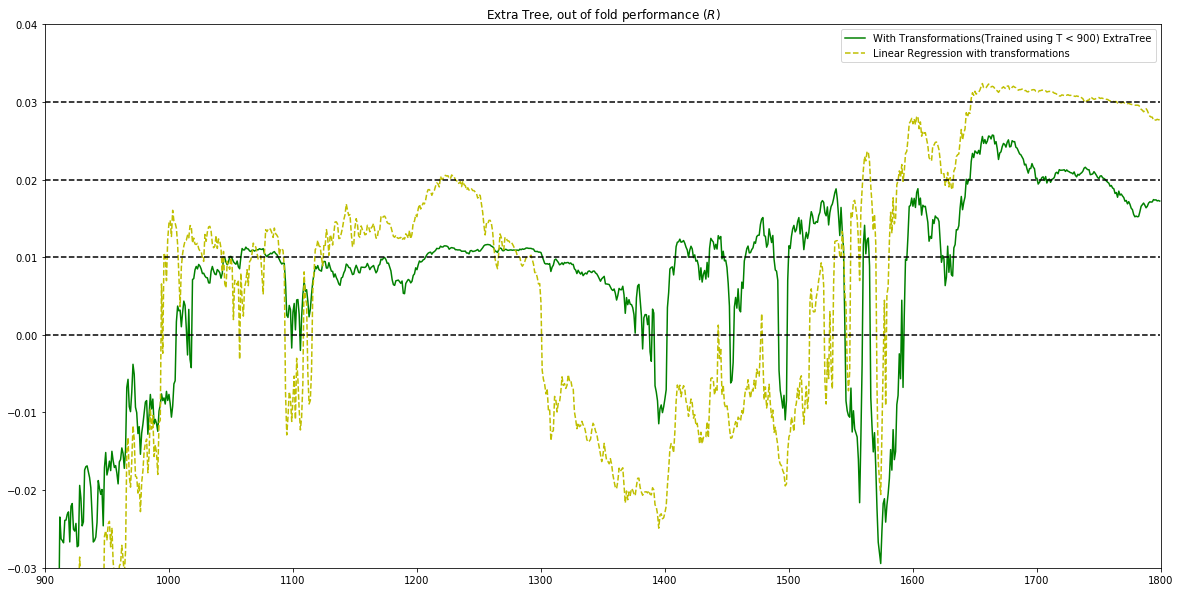

In [121]:
%matplotlib inline
plt.figure(figsize = (20,10))
plt.plot(time_list, model1_et, c='green', label = "With Transformations(Trained using T < 900) ExtraTree")
plt.plot(time_list, model1_train_fh_list, 'y--', label = "Linear Regression with transformations")
plt.plot(time_list, 0.03 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.02 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.01 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.00 + np.zeros(len(time_list)), 'k--')
plt.legend()
plt.xlim([900, 1800])
plt.ylim([-0.03, 0.04])
plt.title("Extra Tree, out of fold performance ($R$)")

## XGboost (without fill)

In [123]:
from scipy.stats import randint as sp_randint
import xgboost as xgb

In [ ]:
from scipy import stats
import xgboost as xgb
#correlation.to_pickle("/home/xin/best_params/corr.p")
correlation = pd.read_pickle("/home/xin/best_params/corr.p")
feature_fast_tree = list(correlation.sort_values("y_abs_corr",ascending = False).iloc[0:60, :]["feature"])

estimator = xgb.XGBRegressor()

param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3],
              'nthread' : [16]
}

xgb_random_search = RandomizedSearchCV(estimator,n_iter=5, 
                         param_distributions=param_dist,verbose = 10,
                         cv = 3, n_jobs = 1)
xgb_random_search.fit(X_train1[feature_fast_tree], y_train1)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=5, colsample_bytree=0.529521893739, min_child_weight=3, subsample=0.326429607922, n_estimators=210, learning_rate=0.025416411281, nthread=16 
[CV]  max_depth=5, colsample_bytree=0.529521893739, min_child_weight=3, subsample=0.326429607922, n_estimators=210, learning_rate=0.025416411281, nthread=16, score=-0.2155953466323861, total=  16.2s
[CV] max_depth=5, colsample_bytree=0.529521893739, min_child_weight=3, subsample=0.326429607922, n_estimators=210, learning_rate=0.025416411281, nthread=16 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


[CV]  max_depth=5, colsample_bytree=0.529521893739, min_child_weight=3, subsample=0.326429607922, n_estimators=210, learning_rate=0.025416411281, nthread=16, score=-0.024302698514883092, total=  16.5s
[CV] max_depth=5, colsample_bytree=0.529521893739, min_child_weight=3, subsample=0.326429607922, n_estimators=210, learning_rate=0.025416411281, nthread=16 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.7s remaining:    0.0s


[CV]  max_depth=5, colsample_bytree=0.529521893739, min_child_weight=3, subsample=0.326429607922, n_estimators=210, learning_rate=0.025416411281, nthread=16, score=-0.026494346491013898, total=  16.5s
[CV] max_depth=3, colsample_bytree=0.508693354965, min_child_weight=3, subsample=0.443274760478, n_estimators=439, learning_rate=0.0218676833472, nthread=16 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.6s remaining:    0.0s


[CV]  max_depth=3, colsample_bytree=0.508693354965, min_child_weight=3, subsample=0.443274760478, n_estimators=439, learning_rate=0.0218676833472, nthread=16, score=-0.20943347336540774, total=  25.2s
[CV] max_depth=3, colsample_bytree=0.508693354965, min_child_weight=3, subsample=0.443274760478, n_estimators=439, learning_rate=0.0218676833472, nthread=16 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV]  max_depth=3, colsample_bytree=0.508693354965, min_child_weight=3, subsample=0.443274760478, n_estimators=439, learning_rate=0.0218676833472, nthread=16, score=-0.007180766639140357, total=  25.7s
[CV] max_depth=3, colsample_bytree=0.508693354965, min_child_weight=3, subsample=0.443274760478, n_estimators=439, learning_rate=0.0218676833472, nthread=16 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s


[CV]  max_depth=3, colsample_bytree=0.508693354965, min_child_weight=3, subsample=0.443274760478, n_estimators=439, learning_rate=0.0218676833472, nthread=16, score=-0.06251228529599451, total=  26.0s
[CV] max_depth=4, colsample_bytree=0.598443218861, min_child_weight=2, subsample=0.936579803437, n_estimators=267, learning_rate=0.0348631917378, nthread=16 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.2min remaining:    0.0s


[CV]  max_depth=4, colsample_bytree=0.598443218861, min_child_weight=2, subsample=0.936579803437, n_estimators=267, learning_rate=0.0348631917378, nthread=16, score=-0.18931428832114627, total=  22.2s
[CV] max_depth=4, colsample_bytree=0.598443218861, min_child_weight=2, subsample=0.936579803437, n_estimators=267, learning_rate=0.0348631917378, nthread=16 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


[CV]  max_depth=4, colsample_bytree=0.598443218861, min_child_weight=2, subsample=0.936579803437, n_estimators=267, learning_rate=0.0348631917378, nthread=16, score=-0.009113038525759842, total=  22.1s
[CV] max_depth=4, colsample_bytree=0.598443218861, min_child_weight=2, subsample=0.936579803437, n_estimators=267, learning_rate=0.0348631917378, nthread=16 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.9min remaining:    0.0s


[CV]  max_depth=4, colsample_bytree=0.598443218861, min_child_weight=2, subsample=0.936579803437, n_estimators=267, learning_rate=0.0348631917378, nthread=16, score=-0.1315286540620828, total=  22.3s
[CV] max_depth=5, colsample_bytree=0.651615240323, min_child_weight=1, subsample=0.782035182487, n_estimators=484, learning_rate=0.0655124509578, nthread=16 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.3min remaining:    0.0s


[CV]  max_depth=5, colsample_bytree=0.651615240323, min_child_weight=1, subsample=0.782035182487, n_estimators=484, learning_rate=0.0655124509578, nthread=16, score=-0.3763002160684057, total=  51.8s
[CV] max_depth=5, colsample_bytree=0.651615240323, min_child_weight=1, subsample=0.782035182487, n_estimators=484, learning_rate=0.0655124509578, nthread=16 
[CV]  max_depth=5, colsample_bytree=0.651615240323, min_child_weight=1, subsample=0.782035182487, n_estimators=484, learning_rate=0.0655124509578, nthread=16, score=-0.03923015665587948, total=  51.4s
[CV] max_depth=5, colsample_bytree=0.651615240323, min_child_weight=1, subsample=0.782035182487, n_estimators=484, learning_rate=0.0655124509578, nthread=16 
[CV]  max_depth=5, colsample_bytree=0.651615240323, min_child_weight=1, subsample=0.782035182487, n_estimators=484, learning_rate=0.0655124509578, nthread=16, score=-0.10810099549466368, total=  52.1s
[CV] max_depth=5, colsample_bytree=0.621298258305, min_child_weight=1, subsample=0

In [256]:
xgb_random_search.best_params_

{'colsample_bytree': 0.52952189373909953,
 'learning_rate': 0.025416411281047324,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 210,
 'nthread': 16,
 'subsample': 0.32642960792156023}

In [126]:
xgb_clf1 = xgb.XGBRegressor(colsample_bytree = 0.52952189373909953,
                             learning_rate = 0.025416411281047324,
                             max_depth = 5,
                            min_child_weight = 3,
                            n_estimators = 210,
                            nthread = 16)
xgb_clf1.fit(X_train[feature_rf[0:30]], y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.5295218937390995, gamma=0,
       learning_rate=0.025416411281047324, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=210, nthread=16,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [127]:
time_list = []
model1_xgb = []
y_pred_list = []
y_actual_list = []

for time in range(900, timemax):
    if time % 100 == 0:
        gc.collect()
        print(time)
    cur_frame = full_frame[full_frame.timestamp == time]
    
    actual_y = list(cur_frame["y"].values)
    pred_y = list(xgb_clf1.predict(cur_frame[feature_rf[0:30]]))
    
    y_pred_list.extend(pred_y)
    y_actual_list.extend(actual_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    time_list.append(time)
    model1_xgb.append(overall_reward)


900
1000
1100
1200
1300
1400
1500
1600
1700


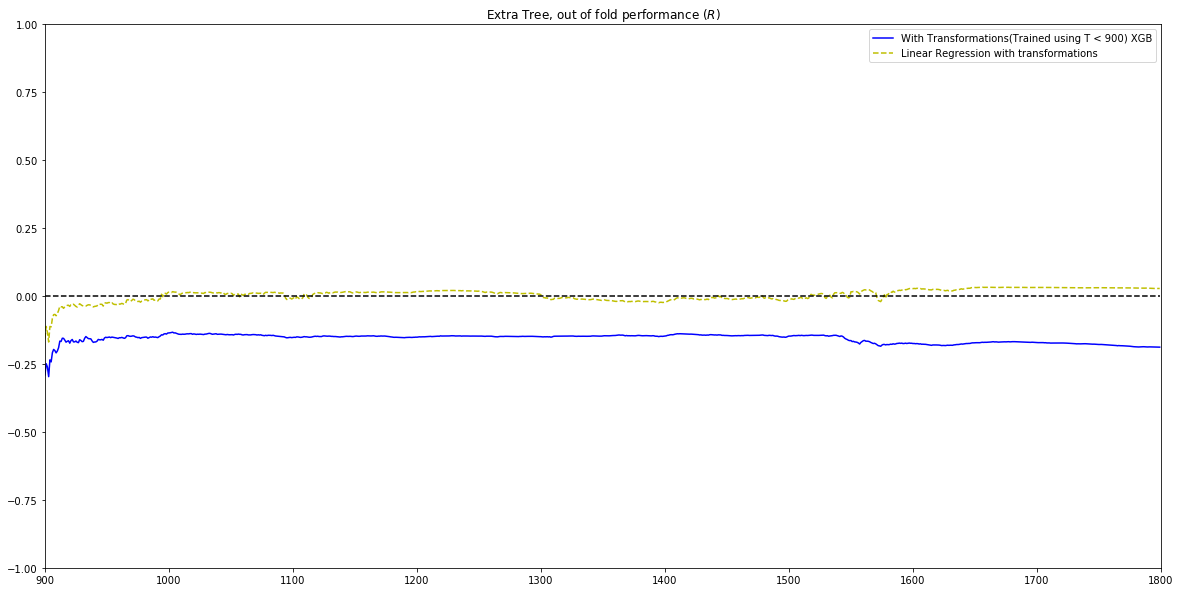

In [132]:
%matplotlib inline
plt.figure(figsize = (20,10))
plt.plot(time_list, model1_xgb, c='blue', label = "With Transformations(Trained using T < 900) XGB")
plt.plot(time_list, model1_train_fh_list, 'y--', label = "Linear Regression with transformations")
plt.plot(time_list, 0.00 + np.zeros(len(time_list)), 'k--')
plt.legend()
plt.xlim([900, 1800])
plt.ylim([-1, 1])
plt.title("Extra Tree, out of fold performance ($R$)")

## Meta regressor

In [217]:
class MSelector(BaseEstimator, TransformerMixin):
    def __init__(self, list_of_features):
        self.list_of_features = list(list_of_features)

    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return pd.DataFrame(x[:,self.list_of_features])

et_columns = []
for i in feature_rf[0:30]:
    et_columns.append(X_train.columns.get_loc(i))

linear_columns = []
for i in model_1_cols:
    linear_columns.append(X_train.columns.get_loc(i))

pip1_et = Pipeline([("SEL", MSelector(list_of_features = et_columns)),
                    ("IMP", Imputer(strategy = "median", axis=0)),
                    ("WIN", Winsorize(lower = 0.01, higher = 99.9)),
                     ("REG", clip_estimator(clf = ExtraTreesRegressor(max_depth = 3,
                                                                     min_samples_split = 3,
                                                                     min_samples_leaf = 3,
                                                                     n_estimators = 10,
                                                                     max_features = 'sqrt',
                                                                     n_jobs = 16)))
                ])

pipElasticNet = Pipeline([("SEL", MSelector(list_of_features = linear_columns)),
                         ("IMP", Imputer(strategy = "median", axis=0)),
                         ("REG", clip_estimator(clf = ElasticNetCV()))
                         ])


stack = StackingCVRegressor(regressors = (pipElasticNet, pip1_et),
                            meta_regressor = RidgeCV(), 
                            use_features_in_secondary=False,
                            cv=2)

In [218]:
stack.fit(np.array(X_train), np.array(y_train))

/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator MSelector modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator MSelector modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator MSelector modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/xin/anaconda/lib/python3.5/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator MSelector modifies parameters in __init__. This

StackingCVRegressor(cv=2,
          meta_regressor=RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False),
          regressors=(Pipeline(memory=None,
     steps=[('SEL', MSelector(list_of_features=[8, 2, 5, 0, 6])), ('IMP', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('REG', clip_estimator(clf=ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
     ...e=False, random_state=None, verbose=0, warm_start=False),
        high=0.093498, low=-0.0860941))])),
          shuffle=True, use_features_in_secondary=False)

In [219]:
time_list = []
model1_stacked = []
y_pred_list = []
y_actual_list = []

for time in range(900, timemax):
    if time % 100 == 0:
        gc.collect()
        print(time)
    cur_frame = full_frame[full_frame.timestamp == time]
    
    actual_y = list(cur_frame["y"].values)
    pred_y = list(stack.predict(np.array(cur_frame)))
    
    y_pred_list.extend(pred_y)
    y_actual_list.extend(actual_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    time_list.append(time)
    model1_stacked.append(overall_reward)

900
1000
1100
1200
1300
1400
1500
1600
1700


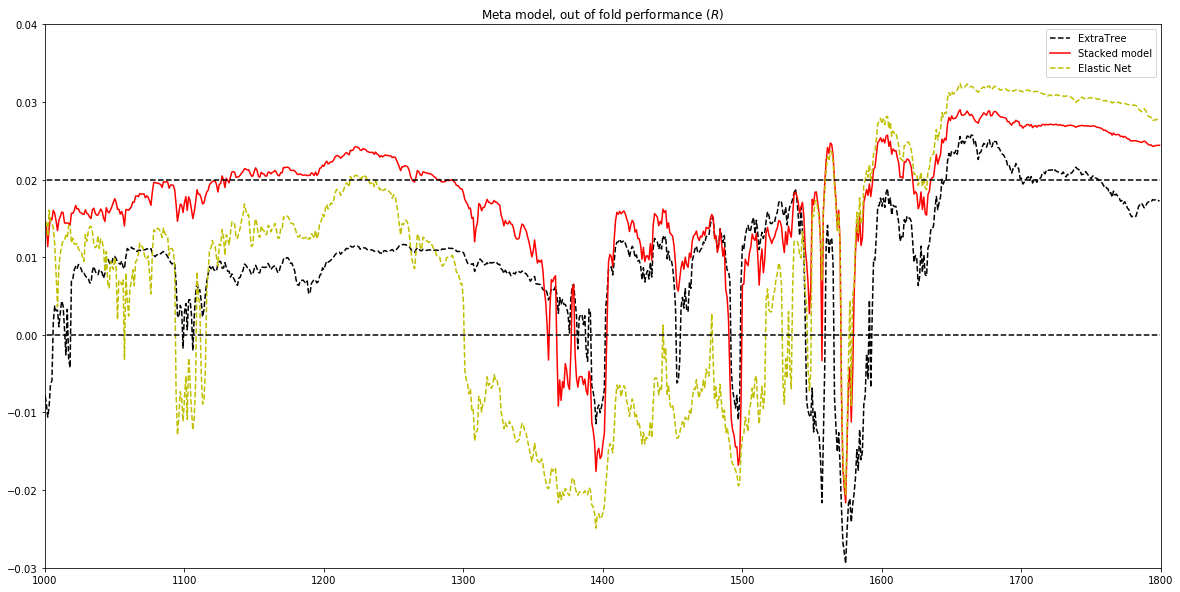

In [229]:
%matplotlib inline
plt.figure(figsize = (20,10))
plt.plot(time_list, model1_et, 'k--', label = "ExtraTree")
plt.plot(time_list, model1_stacked, c='red', label = "Stacked model")
plt.plot(time_list, model1_train_fh_list, 'y--', label = "Elastic Net")
plt.plot(time_list, 0.00 + np.zeros(len(time_list)), 'k--')
plt.plot(time_list, 0.02 + np.zeros(len(time_list)), 'k--')
plt.legend()
plt.xlim([1000, 1800])
plt.ylim([-0.03, 0.04])
plt.title("Meta model, out of fold performance ($R$)")